# Load

In [1]:
source("~/public/SiyuanLuo/projects/benchmark/scripts/evaluation/lib_metrics.R", chdir=TRUE)
source("~/public/SiyuanLuo/projects/benchmark/scripts/clustering/lib_clustering.R", chdir=TRUE)
source("~/public/SiyuanLuo/projects/benchmark/scripts/feature_engineering/func_aggregation.R", chdir=TRUE)
source("~/public/SiyuanLuo/projects/benchmark/scripts/analysis/utils.R", chdir=TRUE)


Attaching package: ‘scales’


The following object is masked from ‘package:viridis’:

    viridis_pal



Attaching package: ‘pals’


The following objects are masked from ‘package:viridis’:

    cividis, inferno, magma, plasma, turbo, viridis


The following objects are masked from ‘package:viridisLite’:

    cividis, inferno, magma, plasma, turbo, viridis




In [2]:
suppressPackageStartupMessages({
    devtools::load_all(path="~/public/SiyuanLuo/projects/benchmark/scripts/feature_engineering/scFeatAgg")
    # devtools::reload(pkg ="~/public/SiyuanLuo/projects/benchmark/scripts/feature_engineering/scFeatAgg", quiet = FALSE)
    require(Signac)
    require(Seurat)
    require(SingleCellExperiment)
    require(mbkmeans)
    library(tidyr)
    library(scran)
})


ℹ Loading scFeatAgg


In [3]:
dataset_ls <- c("Buenrostro_2018", "candidate1", "Cell_line_mixing", "Chen_2019",  "PBMC_multiomics") #"Ma_2019",
k_ls <- c(9, 13, 10, 13, 15)

# candidate1

In [4]:
j <- 2
dataset <- dataset_ls[j]
k_optimal <- k_ls[j]

In [5]:
label_table_file <- "/home/siluo/public/SiyuanLuo/projects/benchmark/raw_data/candidate1/cell_type_annotation.tsv"
barcode_col <- "long_barcode"
label_col <- "cell_type"
sobj_file <- paste0("~/public/SiyuanLuo/projects/benchmark/outputs/", dataset, "/", dataset, "/feature_engineering/R/Signac/by_cluster_peaks/0/default/100.RDS")

In [6]:
output_dir <- "/home/siluo/public/SiyuanLuo/projects/benchmark/scripts/analysis/agg/candidate1_agg_explore/"

## 1. Collect different feature matrix

###  ArchR gene score

In [8]:
suppressPackageStartupMessages({library(ArchR)})
addArchRGenome("hg38")
addArchRThreads(threads = 10)

dir <- paste0("~/public/SiyuanLuo/projects/benchmark/outputs/", dataset, "/", dataset, "/feature_engineering/R/ArchR/tiles/500/default/")
setwd(dir)
proj <- loadArchRProject(path = "proj", force = FALSE, showLogo = FALSE)


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .______      
          /   \     |   _ 

In [9]:
## Add gene score matrix
proj <- addGeneScoreMatrix(proj)
gene_obj <- getMatrixFromProject(proj, useMatrix = "GeneScoreMatrix", binarize = TRUE)
gene_mx <- assay(gene_obj, "GeneScoreMatrix", withDimnames=TRUE)
saveRDS(gene_mx, paste0(output_dir, "GeneScoreMatrix.RDS"))

ArchR logging to : ArchRLogs/ArchR-addGeneScoreMatrix-d460752f7187-Date-2023-05-07_Time-12-16-36.log
If there is an issue, please report to github with logFile!

subThreadhing Disabled since ArchRLocking is TRUE see `addArchRLocking`

2023-05-07 12:16:37 : Batch Execution w/ safelapply!, 0 mins elapsed.

CellinFile1 .addGeneScoreMat useTSS = FALSE

2023-05-07 12:16:43 : Computing Gene Scores using distance relative to GeneBody! , 0.093 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-addGeneScoreMatrix-d460752f7187-Date-2023-05-07_Time-12-16-36.log

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-d4601b8aa4d0-Date-2023-05-07_Time-12-20-39.log
If there is an issue, please report to github with logFile!

2023-05-07 12:21:30 : Organizing colData, 0.839 mins elapsed.

2023-05-07 12:21:30 : Organizing rowData, 0.839 mins elapsed.

2023-05-07 12:21:30 : Organizing rowRanges, 0.839 mins elapsed.

2023-05-07 12:21:30 : Organizing Assays (1 of 1), 0.839 mins elapsed.

2023-0

In [10]:
# create sce object
sce <- SingleCellExperiment(list(counts=gene_mx))
# normalize the meta-features
sce <- scuttle::logNormCounts(sce)
dec <- modelGeneVar(sce)

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


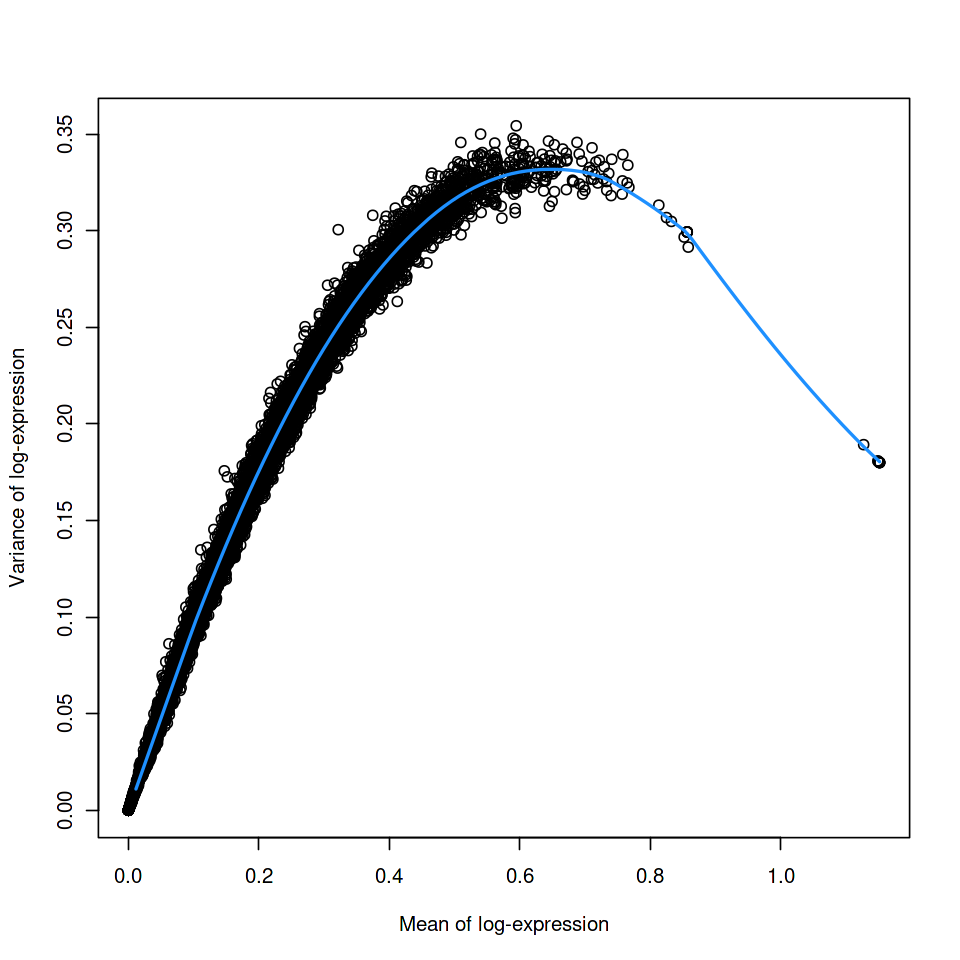

In [11]:
# Visualizing the fit:
fit <- metadata(dec)

options(repr.plot.width=8, repr.plot.height=8)
plot(fit$mean, fit$var, xlab="Mean of log-expression",
    ylab="Variance of log-expression")
curve(fit$trend(x), col="dodgerblue", add=TRUE, lwd=2)

In [12]:
chosen <- getTopHVGs(dec, prop=0.5)
sce_sub <- sce[chosen,]
dim(sce_sub)

[1]  7352 20204

In [13]:
# pca1 <- scater::runPCA(t(logcounts(sce)), center=TRUE, scale=TRUE, rank=100)
# Fmat1 <- as.matrix(pca1$x)

pca2 <- scater::runPCA(t(logcounts(sce_sub)), center=TRUE, scale=TRUE, rank=100)
Fmat2 <- as.matrix(pca2$x)
write.table(Fmat2, file = paste0(output_dir, "ArchR.Gene.sub.pca.tsv"), sep = "\t", quote = FALSE, col.names = FALSE)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.1 GiB”


### ArchR gene score + agg

In [14]:
agg_counts <- scDblFinder:::aggregateFeatures(
        gene_mx,
        dims.use = seq(2L, 12L),
        k = 1000,
        num_init = 3,
        use.subset = 2000,
        norm.fn = Signac::RunTFIDF, 
        twoPass=TRUE)
saveRDS(agg_counts, paste0(output_dir, "ArchR.Gene.Agg.RDS"))

Performing TF-IDF normalization

Second iteration...

Performing TF-IDF normalization



In [15]:
# create sce object
sce <- SingleCellExperiment(list(counts=agg_counts))
# normalize the meta-features
sce <- scuttle::logNormCounts(sce)

pca <- scater::runPCA(t(logcounts(sce)), center=TRUE, scale=TRUE, rank=100)
Fmat <- as.matrix(pca$x)
write.table(Fmat, file = paste0(output_dir, "ArchR.Gene.Agg.pca.tsv"), sep = "\t", quote = FALSE, col.names = FALSE)

### ArchR tile + agg

In [16]:
tile_obj <- getMatrixFromProject(proj, useMatrix = "TileMatrix", binarize = TRUE)
tile_mx <- assay(tile_obj, "TileMatrix", withDimnames=TRUE)
saveRDS(tile_mx, paste0(output_dir, "TileMatrix.RDS"))

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-d46068866515-Date-2023-05-07_Time-14-15-00.log
If there is an issue, please report to github with logFile!

2023-05-07 14:16:17 : Organizing colData, 1.279 mins elapsed.

2023-05-07 14:16:17 : Organizing rowData, 1.28 mins elapsed.

2023-05-07 14:16:17 : Organizing rowRanges, 1.28 mins elapsed.

2023-05-07 14:16:17 : Organizing Assays (1 of 1), 1.28 mins elapsed.

2023-05-07 14:16:17 : Constructing SummarizedExperiment, 1.28 mins elapsed.

2023-05-07 14:16:18 : Finished Matrix Creation, 1.302 mins elapsed.



In [17]:
tile_mx <- readRDS(paste0(output_dir, "TileMatrix.RDS"))
dim(tile_mx)

[1] 6062095   20204

In [18]:
# select tiles for agg
min.cutoff <- 20
hvf.info <- FindTopFeatures(object = tile_mx, min.cutoff = min.cutoff)
# percentile.use <- as.numeric(x = sub(pattern = "q", replacement = "", x = as.character(x = min.cutoff))) / 100
variable.features <- rownames(hvf.info[hvf.info$count > min.cutoff, ]) # count is cell count
dim(hvf.info)
length(variable.features)

[1] 6062095       2

[1] 836325

In [19]:
tile_mx_sub <- tile_mx[as.numeric(variable.features),]
agg_counts <- scDblFinder:::aggregateFeatures(
        tile_mx_sub,
        dims.use = seq(2L, 12L),
        k = 1000,
        num_init = 3,
        use.subset = 2000,
        norm.fn = Signac::RunTFIDF, 
        twoPass=TRUE)
saveRDS(agg_counts, paste0(output_dir, "ArchR.Tile.sub.Agg.RDS"))

Performing TF-IDF normalization

Second iteration...

Performing TF-IDF normalization



In [ ]:
# agg_counts <- scDblFinder:::aggregateFeatures(
#         tile_mx,
#         dims.use = seq(2L, 12L),
#         k = 1000,
#         num_init = 3,
#         use.subset = 2000,
#         norm.fn = Signac::RunTFIDF, 
#         twoPass=FALSE)
# saveRDS(agg_counts, "agg_counts_from_tiles.RDS")

In [ ]:
agg_counts <- readRDS(paste0(output_dir, "ArchR.Tile.sub.Agg.RDS"))

In [20]:
# create sce object
sce <- SingleCellExperiment(list(counts=agg_counts))
# normalize the meta-features
sce <- scuttle::logNormCounts(sce)

pca <- scater::runPCA(t(logcounts(sce)), center=TRUE, scale=TRUE, rank=100)
Fmat <- as.matrix(pca$x)
write.table(Fmat, file = paste0(output_dir, "ArchR.Tile.sub.Agg.pca.tsv"), sep = "\t", quote = FALSE, col.names = FALSE)

### Signac, Signac + Agg

In [8]:
embedding_file_Signac <- paste0("~/public/SiyuanLuo/projects/benchmark/outputs/", dataset, "/", dataset, "/feature_engineering/R/Signac/by_cluster_peaks/0/default/100.tsv")
embedding_file_Signac.Agg.all <- paste0("~/public/SiyuanLuo/projects/benchmark/outputs/", dataset, "/", dataset, "/feature_engineering/R/aggregation/default/0/default/100.tsv")

### ArchR tile

In [8]:
embedding_file_ArchR <- paste0("~/public/SiyuanLuo/projects/benchmark/outputs/", dataset, "/", dataset, "/feature_engineering/R/ArchR/tiles/500/default/100.tsv")

### Signac embedding as the twoPass

In [33]:
sobj <- readRDS(sobj_file)
feature_matrix <- GetAssayData(sobj[["by_cluster_peaks"]], slot = "counts") # feature-by-cell matrix!

signac_embed <- t(Embeddings(Reductions(sobj, "lsi_by_cluster_peaks")))

In [34]:
dim(feature_matrix)
dim(signac_embed)

[1] 291614  20204

[1]   100 20204

In [35]:
agg_counts <- scFeatAgg::aggregateFeatures(
        feature_matrix,
        dims.use = seq(2L, 12L),
        k = 1000,
        num_init = 3,
        use.subset = 2000,
        norm.fn = Signac::RunTFIDF, 
        twoPass=signac_embed[1:15,])
saveRDS(agg_counts, paste0(output_dir, "Signac.twoPass.Agg.RDS"))

Warning message in !is.null(colnames(twoPass)) && colnames(twoPass) != colnames(x):
“'length(x) = 20204 > 1' in coercion to 'logical(1)'”
Clustering cells for second iteration...

Performing TF-IDF normalization



In [45]:
# create sce object
sce <- SingleCellExperiment(list(counts=agg_counts))
# normalize the meta-features
sce <- scuttle::logNormCounts(sce)

pca <- scater::runPCA(t(logcounts(sce)), center=TRUE, scale=TRUE, rank=100)
Fmat <- as.matrix(pca$x)
write.table(Fmat, file = paste0(output_dir, "Signac.twoPass.Agg.pca.tsv"), sep = "\t", quote = FALSE, col.names = FALSE)

## 2. Add all embedding file to sobj

In [9]:
embedding_file_ArchR.Agg.sub <- paste0(output_dir, "ArchR.Tile.sub.Agg.pca.tsv")
embedding_file_GeneScore.sub <- paste0(output_dir, "ArchR.Gene.sub.pca.tsv")
embedding_file_GeneScore.agg <- paste0(output_dir, "ArchR.Gene.Agg.pca.tsv")
embedding_file_Signac.twoPass.agg <- paste0(output_dir, "Signac.twoPass.Agg.pca.tsv")

In [38]:
ndim <- 30

In [10]:
# add the embedding matrix to Signac object
sobj <- readRDS(sobj_file)

sobj <- add_labels(sobj, label_table_file, barcode_col, label_col)
sobj <- add_embedding(sobj, embedding_file_Signac.Agg.all, embed_name="signac.agg", max_dim=ndim)
sobj <- add_embedding(sobj, embedding_file_Signac, embed_name="signac", max_dim=ndim)
sobj <- add_embedding(sobj, embedding_file_ArchR, embed_name="archr", max_dim=ndim)
sobj <- add_embedding(sobj, embedding_file_ArchR.Agg.sub, embed_name="archr.agg", max_dim=ndim)
sobj <- add_embedding(sobj, embedding_file_GeneScore.sub, embed_name="archr.gene", max_dim=ndim)
sobj <- add_embedding(sobj, embedding_file_GeneScore.agg, embed_name="archr.gene.agg", max_dim=ndim)
sobj <- add_embedding(sobj, embedding_file_Signac.twoPass.agg, embed_name="signac.twopass.agg", max_dim=ndim)

Warning message:
“No columnames present in cell embeddings, setting to 'LSI_1:30'”
Warning message:
“No columnames present in cell embeddings, setting to 'LSI_1:30'”
Warning message:
“No columnames present in cell embeddings, setting to 'LSI_1:30'”
Warning message:
“No columnames present in cell embeddings, setting to 'LSI_1:30'”
Warning message:
“No columnames present in cell embeddings, setting to 'LSI_1:30'”
Warning message:
“No columnames present in cell embeddings, setting to 'LSI_1:30'”
Warning message:
“No columnames present in cell embeddings, setting to 'LSI_1:30'”


In [11]:
setwd("~/public/SiyuanLuo/projects/benchmark/scripts/analysis/agg/candidate1_agg_explore")
saveRDS(sobj, "candidate1_sobj_ndim30.RDS")

## 3. Do clustering

In [7]:
setwd("~/public/SiyuanLuo/projects/benchmark/scripts/analysis/agg/candidate1_agg_explore")
sobj <- readRDS("candidate1_sobj_ndim30.RDS")

In [7]:
setwd("~/public/SiyuanLuo/projects/benchmark/scripts/analysis/agg/candidate1_agg_explore")
sobj <- readRDS("candidate1_sobj_ndim30_signac_clustering.RDS")


In [9]:
# options(warn=-1)
embed_ls <- c("signac.agg", "signac", "archr", "archr.agg", "archr.gene", "archr.gene.agg", "signac.twopass.agg")
# embed_ls <- c("signac.agg", "signac", "signac.twopass.agg")
# embed_ls <- c("archr", "archr.agg", "archr.gene", "archr.gene.agg")
# embed_ls <- c("archr.gene", "archr.gene.agg")
# embed_ls <- c("archr", "archr.agg")
r_ls <- c(0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4)

for(embed_name in embed_ls){
    print(embed_name)
    name1 <- paste0("nn_", embed_name)
    name2 <- paste0("snn_", embed_name)
    sobj <- FindNeighbors(object = sobj, 
                            reduction = embed_name, 
                            graph.name = c(name1, name2),
                            verbose = FALSE
                        )
    sobj@graphs[[name1]] <- as.Graph(sobj@graphs[[name1]])
    sobj@graphs[[name2]] <- as.Graph(sobj@graphs[[name2]])
    ndim0 <- dim(sobj@reductions[[embed_name]])[2]
    sobj <- RunUMAP(sobj, 
            reduction = embed_name,
            dims = 1:ndim0,
            reduction.name=paste0("umap_" ,embed_name),
            verbose = FALSE)
    for(r in r_ls){
        print(r)
        sobj <- FindClusters(object = sobj, 
                    verbose = FALSE, 
                    algorithm = 4,
                    resolution = r,
                    graph.name = name2
                    )
        sobj@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]] <- sobj$seurat_clusters
        gc()
    }
}

saveRDS(sobj, "candidate1_sobj_ndim30_all_clustering.RDS")

[1] "archr"


Warning message:
“Cannot add objects with duplicate keys (offending key: UMAP_), setting key to 'umap_archr_'”


[1] 0.05


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.0 GiB”
Warning message:
“Adding a command log without an assay associated with it”


[1] 0.1


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.0 GiB”
Warning message:
“Adding a command log without an assay associated with it”


[1] 0.15


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.0 GiB”
Warning message:
“Adding a command log without an assay associated with it”


[1] 0.2


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.0 GiB”
Warning message:
“Adding a command log without an assay associated with it”


[1] 0.25


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.0 GiB”
Warning message:
“Adding a command log without an assay associated with it”


[1] 0.3


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.0 GiB”
Warning message:
“Adding a command log without an assay associated with it”


[1] 0.35


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.0 GiB”
Warning message:
“Adding a command log without an assay associated with it”


[1] 0.4


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.0 GiB”
Warning message:
“Adding a command log without an assay associated with it”


[1] "archr.agg"


Warning message:
“Cannot add objects with duplicate keys (offending key: UMAP_), setting key to 'umap_archr.agg_'”


[1] 0.05


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.0 GiB”
Warning message:
“Adding a command log without an assay associated with it”


[1] 0.1


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.0 GiB”
Warning message:
“Adding a command log without an assay associated with it”


[1] 0.15


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.0 GiB”
Warning message:
“Adding a command log without an assay associated with it”


[1] 0.2


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.0 GiB”
Warning message:
“Adding a command log without an assay associated with it”


[1] 0.25


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.0 GiB”
Warning message:
“Adding a command log without an assay associated with it”


[1] 0.3


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.0 GiB”
Warning message:
“Adding a command log without an assay associated with it”


[1] 0.35


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.0 GiB”
Warning message:
“Adding a command log without an assay associated with it”


[1] 0.4


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.0 GiB”
Warning message:
“Adding a command log without an assay associated with it”


In [12]:
setwd("~/public/SiyuanLuo/projects/benchmark/scripts/analysis/agg/candidate1_agg_explore")
sobj <- readRDS("candidate1_sobj_ndim30_all_clustering.RDS")

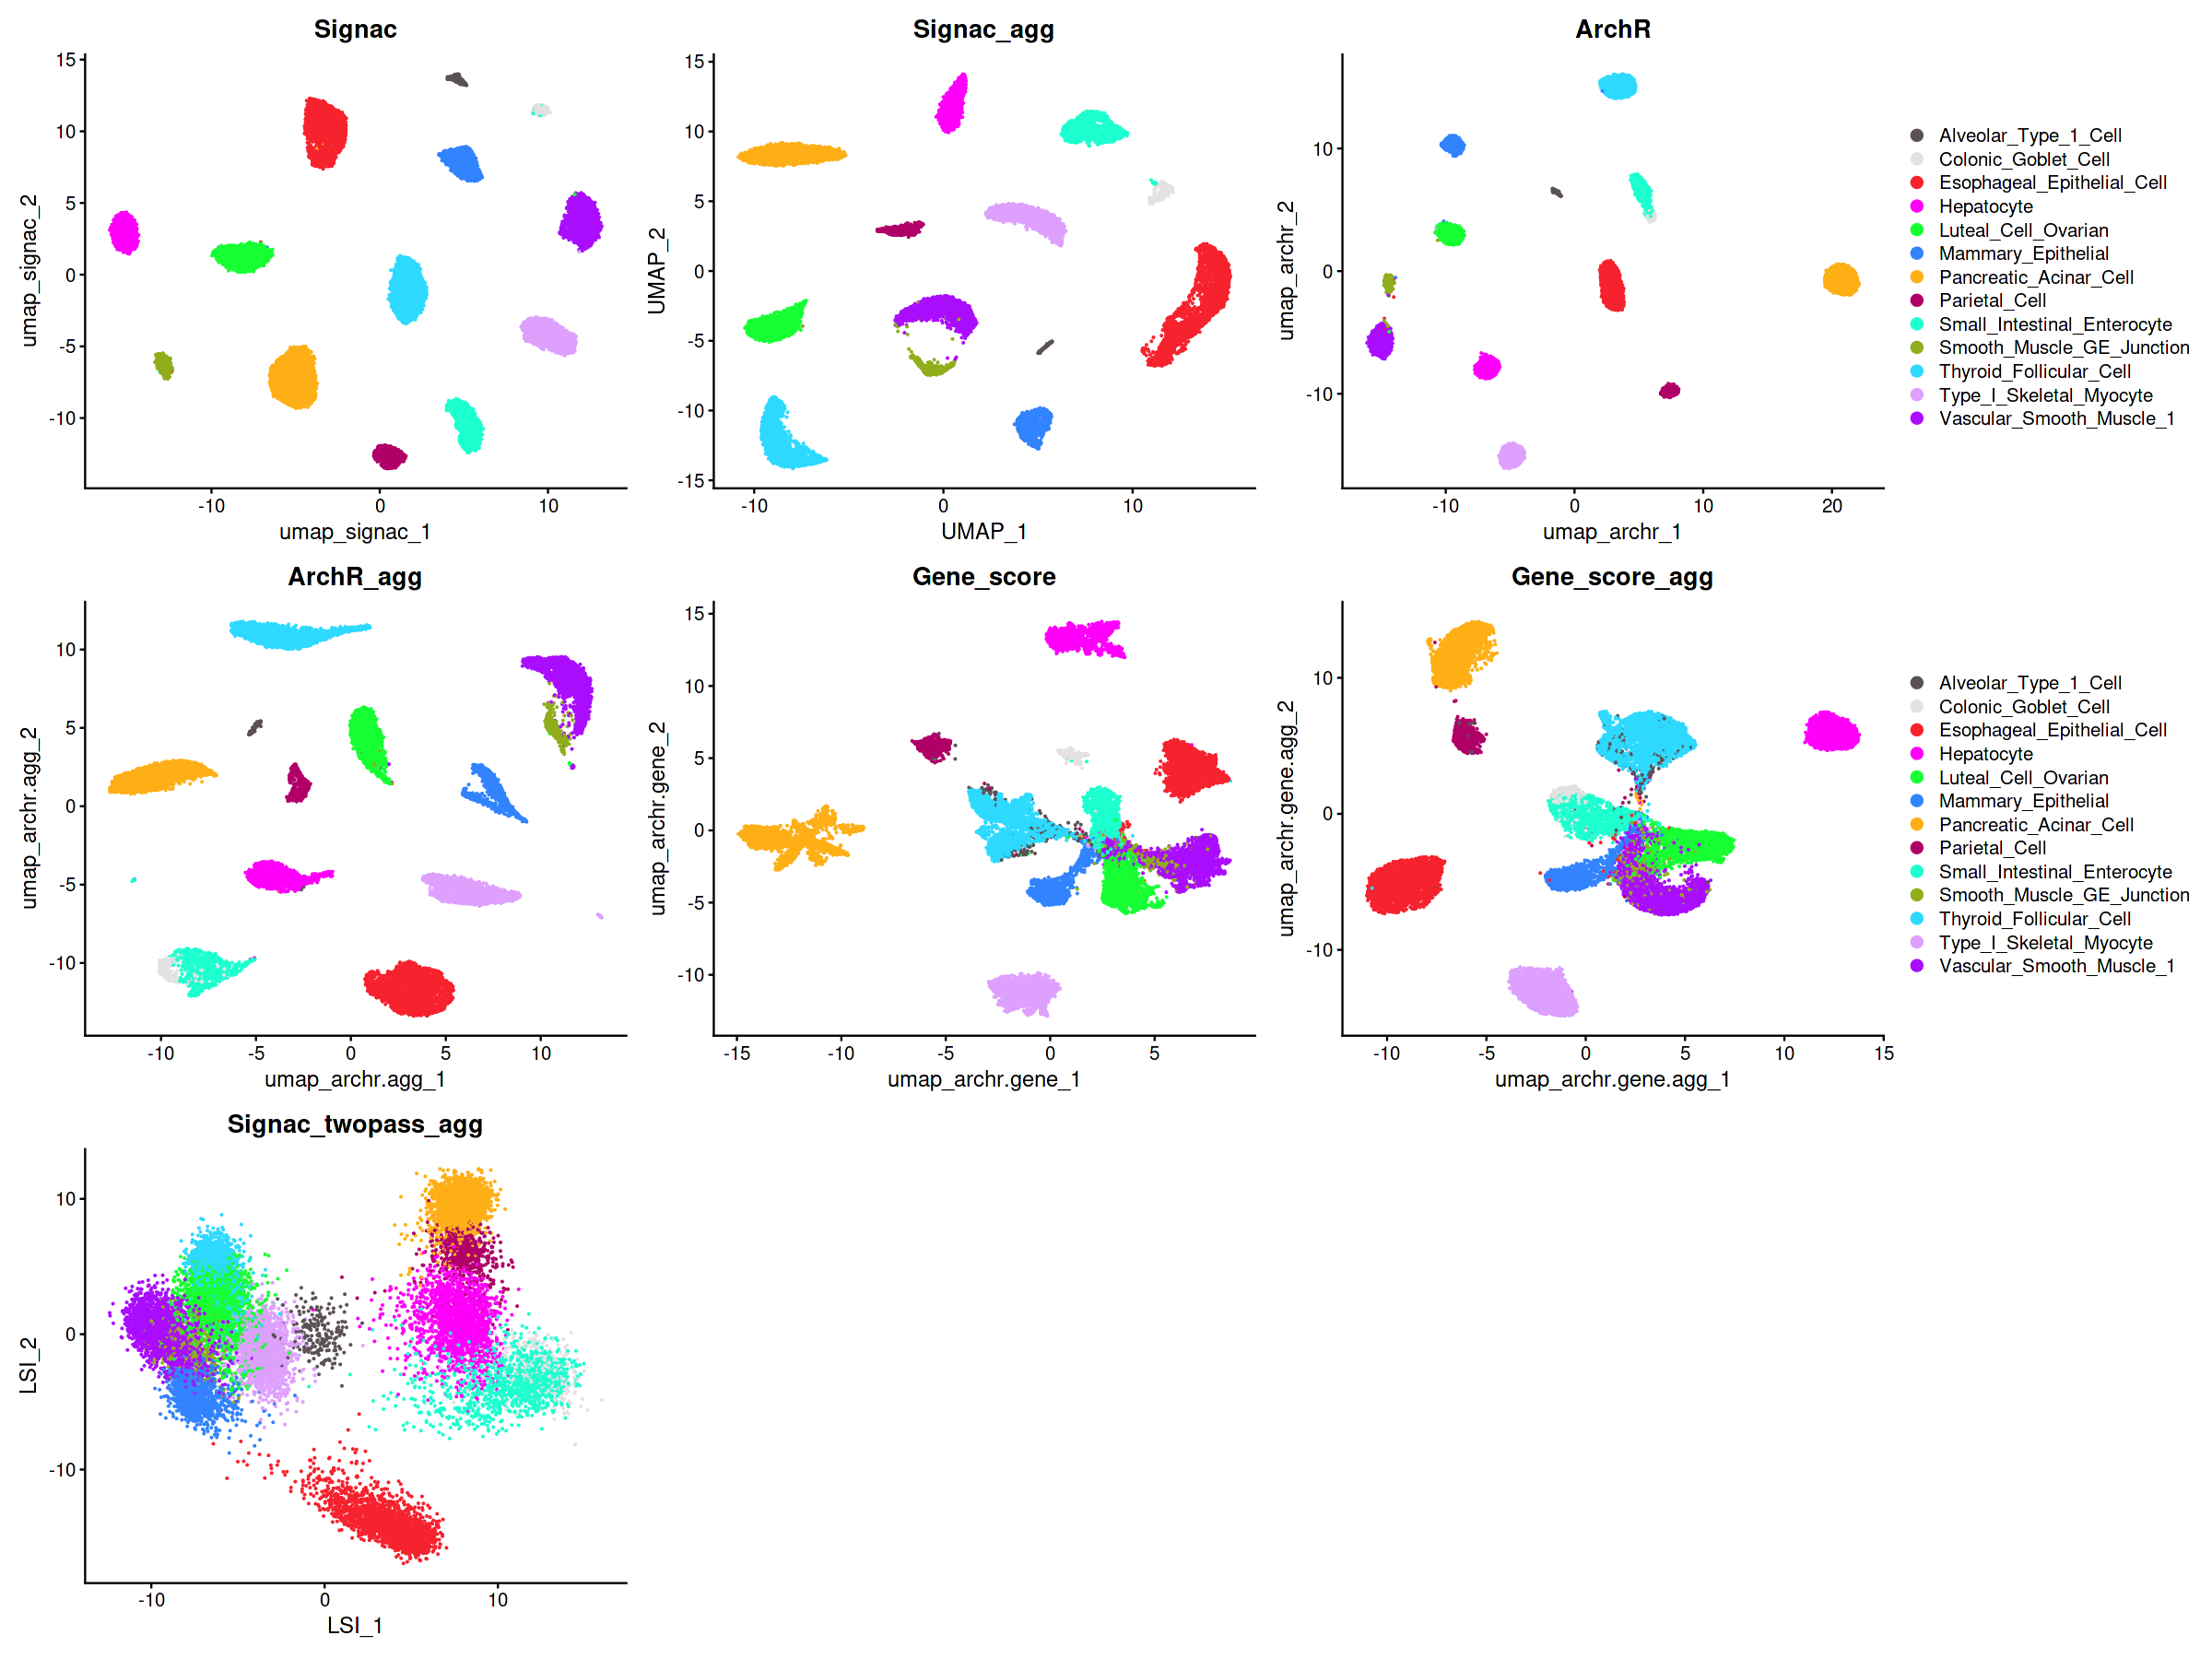

In [13]:
options(repr.plot.width=20, repr.plot.height=15)

par(mfrow=c(4,2))

p1 <- DimPlot(sobj, reduction = "umap_signac", label = F, repel=T, 
        group.by = "ground_truth", cols="polychrome")  + ggtitle("Signac")  + NoLegend()
p2 <- DimPlot(sobj, reduction = "umap_signac.agg", label = F, repel=T, 
        group.by = "ground_truth", cols="polychrome")  + ggtitle("Signac_agg") + NoLegend()

p3 <- DimPlot(sobj, reduction = "umap_archr", label = F, repel=T, 
        group.by = "ground_truth", cols="polychrome")  + ggtitle("ArchR") #+ NoLegend()
p4 <- DimPlot(sobj, reduction = "umap_archr.agg", label = F, repel=T, 
        group.by = "ground_truth", cols="polychrome")  + ggtitle("ArchR_agg") + NoLegend()

p5 <- DimPlot(sobj, reduction = "umap_archr.gene", label = F, repel=T, 
        group.by = "ground_truth", cols="polychrome")  + ggtitle("Gene_score") + NoLegend()
p6 <- DimPlot(sobj, reduction = "umap_archr.gene.agg", label = F, repel=T, 
        group.by = "ground_truth", cols="polychrome")  + ggtitle("Gene_score_agg") #+ NoLegend()

p7 <- DimPlot(sobj, reduction = "signac.twopass.agg", label = F, repel=T, 
        group.by = "ground_truth", cols="polychrome")  + ggtitle("Signac_twopass_agg") + NoLegend()
        

p1 + p2 + p3 + p4 + p5 + p6 + p7

In [13]:
# embed_ls <- c("signac.agg", "signac", "archr", "archr.agg", "archr.gene", "archr.gene.agg")
embed_ls <- c("signac.agg", "signac", "archr", "archr.agg", "archr.gene", "archr.gene.agg", "signac.twopass.agg")
r_ls <- c(0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4)

df <- data.frame(ARI=c(), resolution=c(), method=c(), n_cluster=c())
for(embed_name in embed_ls){
    for(r in r_ls){
    pred <- sobj@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
    ari <- aricode::ARI(sobj$ground_truth, pred)
    # print(embed_name)
    # print(ari)
    # print(max(as.numeric(unique(pred))))
    df <- rbind(df, list(ARI=ari, resolution=r, method=embed_name, n_cluster=max(as.numeric(unique(pred)))))
    }   
}


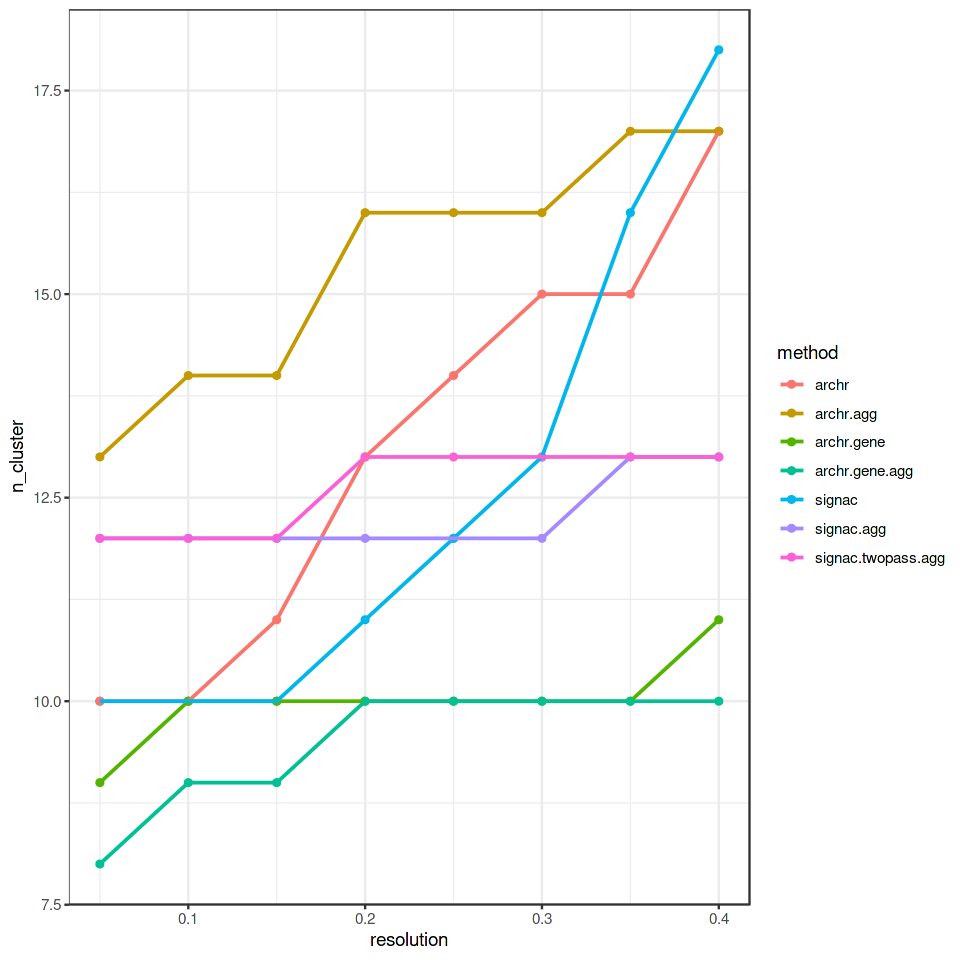

In [17]:
options(repr.plot.width=8, repr.plot.height=8)

df %>% 
  ggplot(aes(x=resolution, y=n_cluster, color=method)) + 
  geom_point(size=1.5) +
  geom_line(size=0.8, aes(x=resolution, y=n_cluster, color=method)) + 
  xlab("resolution") +
  ylab("n_cluster") +
#   geom_vline(xintercept=15, color = "red", linetype = "dashed") +
  theme_bw() #+

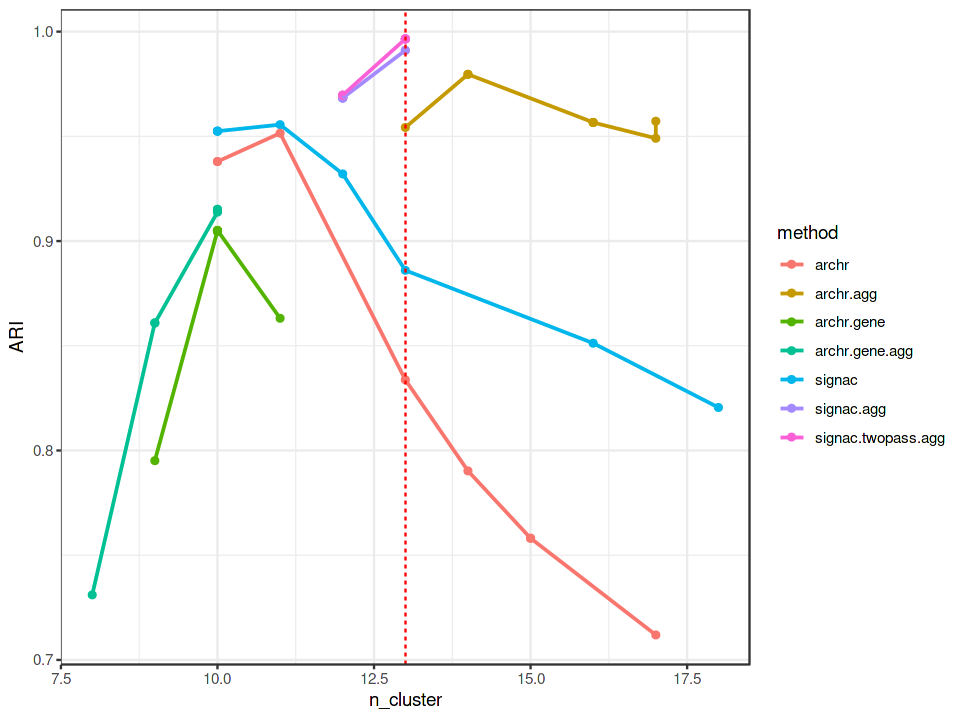

In [16]:
options(repr.plot.width=8, repr.plot.height=6)

df %>% 
  ggplot(aes(x=n_cluster, y=ARI, color=method)) + 
  geom_point(size=1.5) +
  geom_line(size=0.8, aes(x=n_cluster, y=ARI, color=method)) + 
  xlab("n_cluster") +
  ylab("ARI") +
  geom_vline(xintercept=13, color = "red", linetype = "dashed") +
  theme_bw() #+
  # geom_errorbar(aes(ymin = min_value, ymax = max_value), width = 0.2, linetype = "dashed") +
#   scale_colour_manual(values = brewer.pal(10, "Paired")[c(1,3:6,7,9:10)])

## Check cross table

In [21]:
# check the cross table
df_best <- df  %>%
  group_by(method) %>%
  filter(ARI == max(ARI)) %>%
  ungroup()

df_best <- df_best[!duplicated(df_best[, c("method")]), ]
df_best

ARI       resolution method             n_cluster
1 0.9910685 0.35       signac.agg         13       
2 0.9555852 0.20       signac             11       
3 0.9514962 0.15       archr              11       
4 0.9796228 0.10       archr.agg          14       
5 0.9051215 0.35       archr.gene         10       
6 0.9151554 0.35       archr.gene.agg     10       
7 0.9965073 0.20       signac.twopass.agg 13

In [30]:
ground_truth <- sobj$ground_truth
library(aricode)

# A tibble: 1 × 4
    ARI resolution method     n_cluster
  <dbl>      <dbl> <chr>          <dbl>
1 0.991       0.35 signac.agg        13


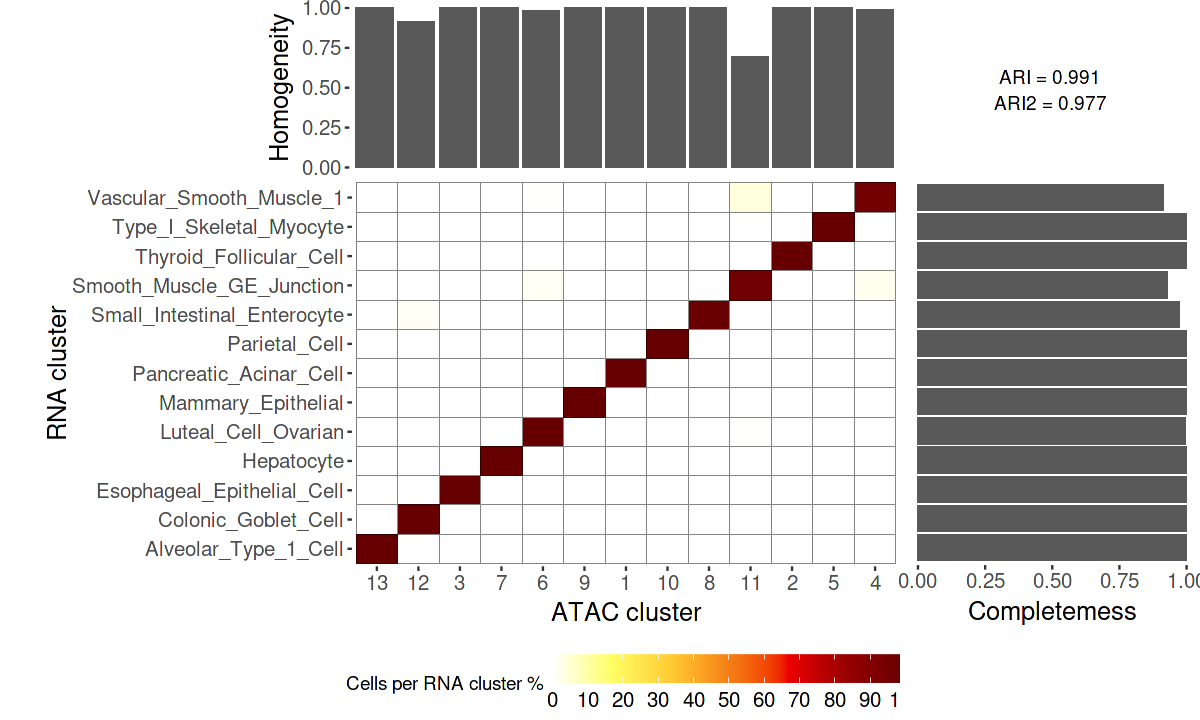

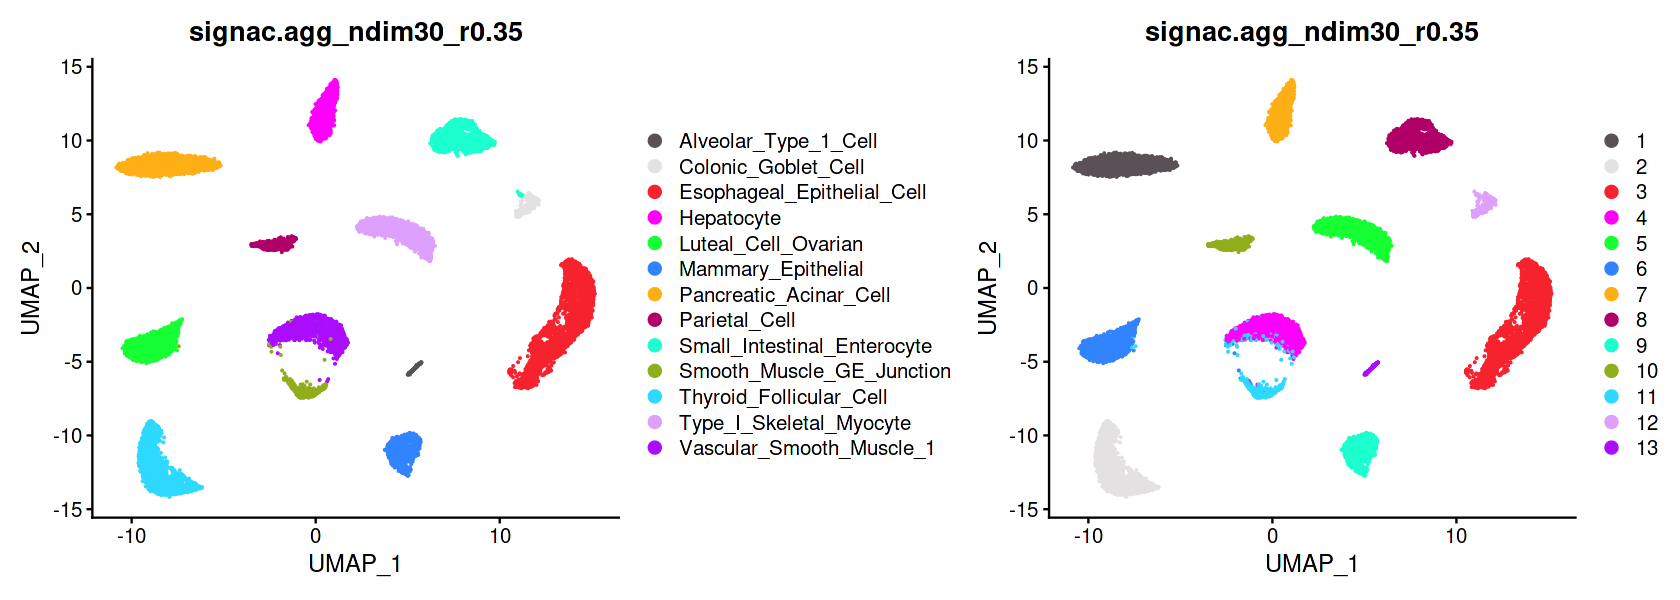

In [50]:
i <- 1
print(df_best[i,])
embed_name <- df_best$method[i]
r <- df_best$resolution[i]
clusterings <- sobj@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
p1 <- cross_table_plot(ground_truth, clusterings, a=1.5, b=5.7, c=2)
p2 <- DimPlot(sobj, reduction = paste0("umap_" ,embed_name), label = F, repel=T, 
        group.by = "ground_truth", cols="polychrome")  + ggtitle(paste0(embed_name, "_ndim", ndim, "_r", r)) 
p3 <- DimPlot(sobj, reduction = paste0("umap_" ,embed_name), label = F, repel=T, 
        group.by = paste0("clustering_" ,embed_name, "_r", r), cols="polychrome")  + ggtitle(paste0(embed_name, "_ndim", ndim, "_r", r)) 


options(repr.plot.width=10, repr.plot.height=6)
p1 
options(repr.plot.width=14, repr.plot.height=5)
p2 + p3

# A tibble: 1 × 4
    ARI resolution method n_cluster
  <dbl>      <dbl> <chr>      <dbl>
1 0.956        0.2 signac        11


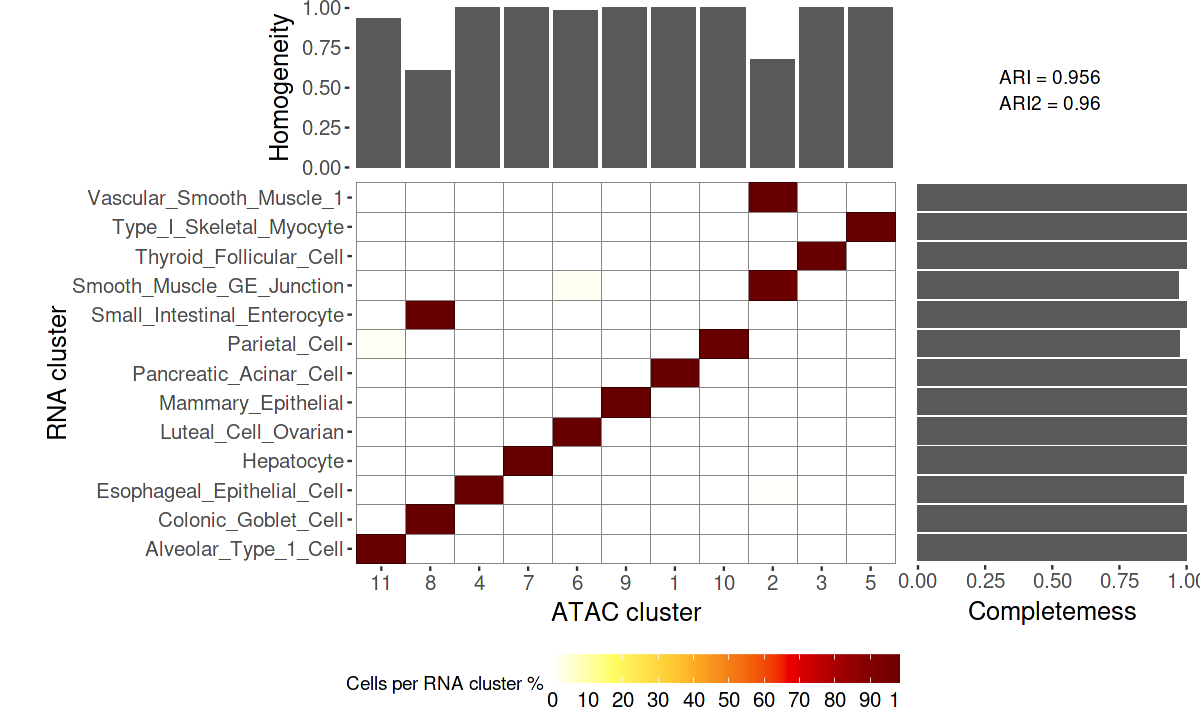

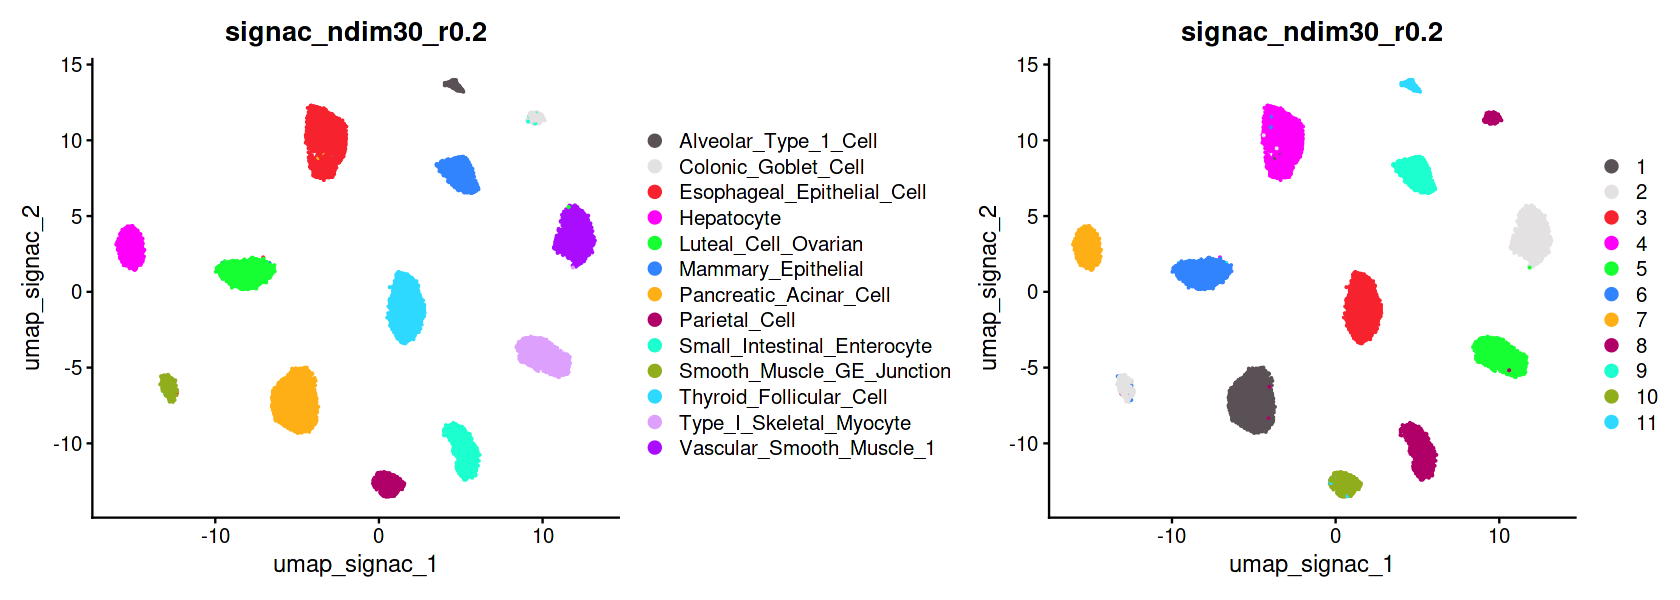

In [52]:
i <- 2
print(df_best[i,])
embed_name <- df_best$method[i]
r <- df_best$resolution[i]
clusterings <- sobj@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
p1 <- cross_table_plot(ground_truth, clusterings, a=1.5, b=5.7, c=2)
p2 <- DimPlot(sobj, reduction = paste0("umap_" ,embed_name), label = F, repel=T, 
        group.by = "ground_truth", cols="polychrome")  + ggtitle(paste0(embed_name, "_ndim", ndim, "_r", r)) 
p3 <- DimPlot(sobj, reduction = paste0("umap_" ,embed_name), label = F, repel=T, 
        group.by = paste0("clustering_" ,embed_name, "_r", r), cols="polychrome")  + ggtitle(paste0(embed_name, "_ndim", ndim, "_r", r)) 


options(repr.plot.width=10, repr.plot.height=6)
p1 
options(repr.plot.width=14, repr.plot.height=5)
p2 + p3

# A tibble: 1 × 4
    ARI resolution method n_cluster
  <dbl>      <dbl> <chr>      <dbl>
1 0.951       0.15 archr         11


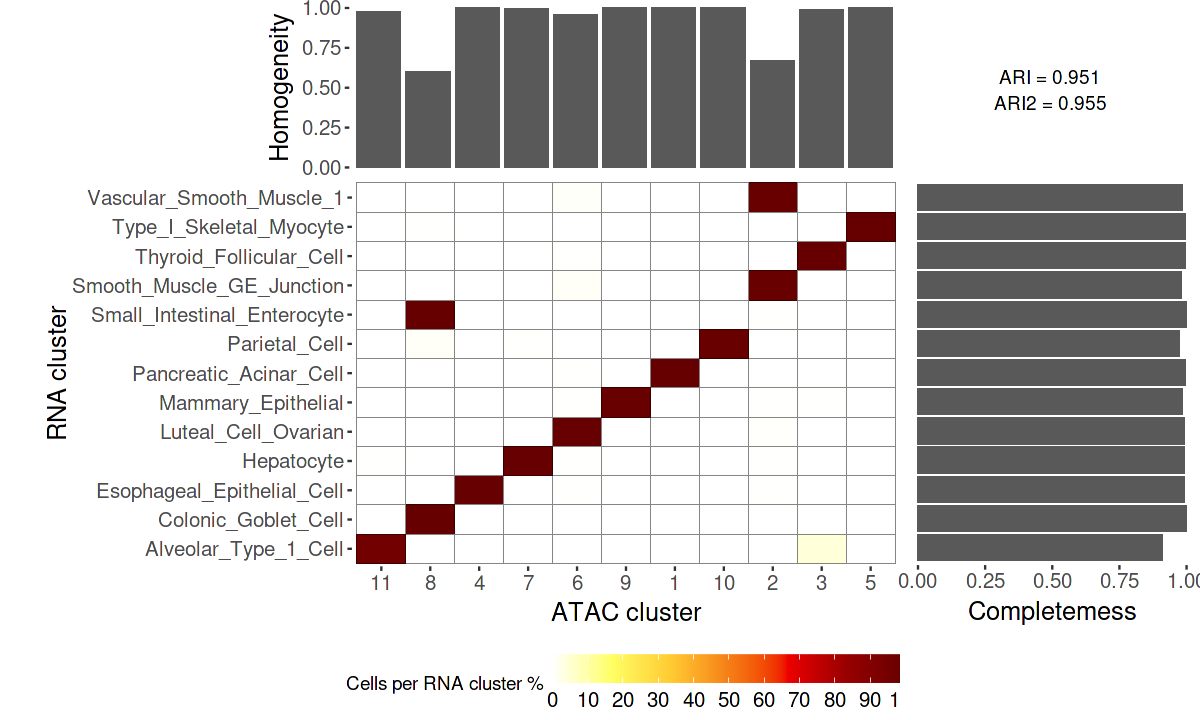

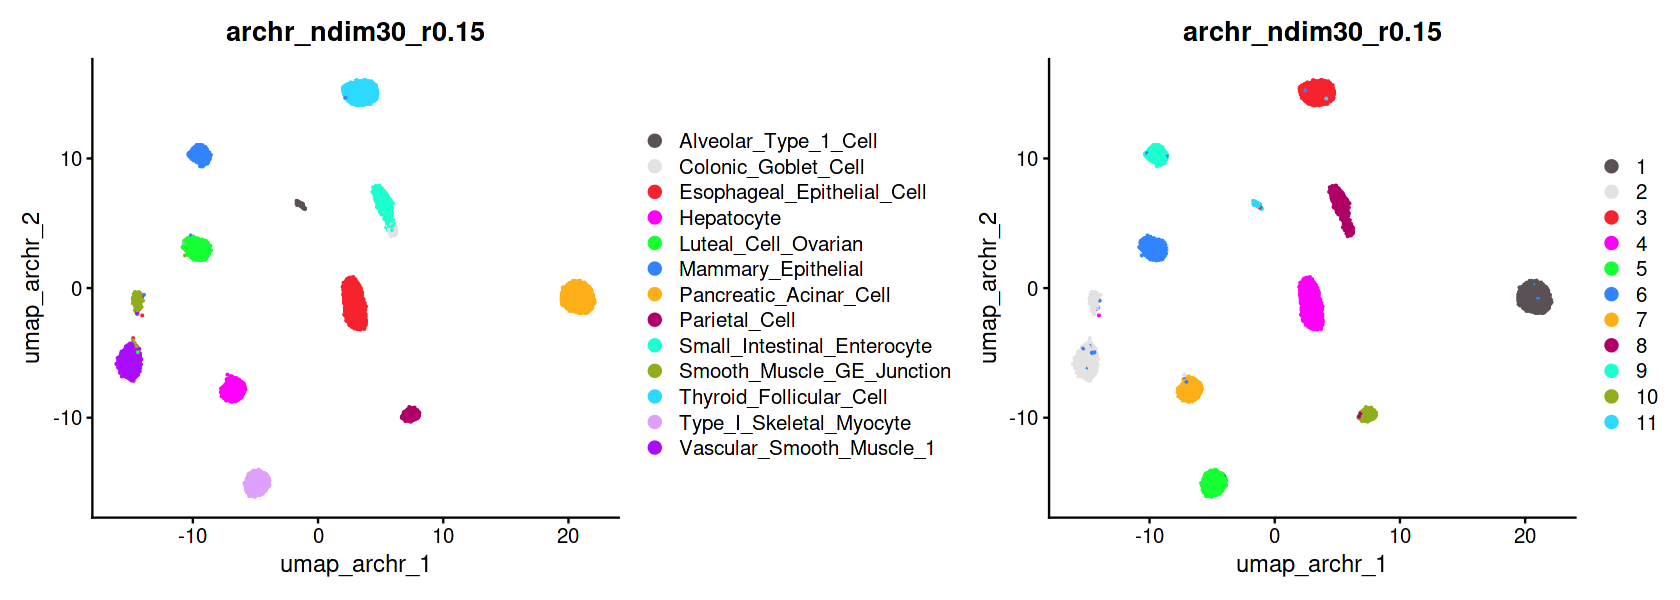

In [53]:
i <- 3
print(df_best[i,])
embed_name <- df_best$method[i]
r <- df_best$resolution[i]
clusterings <- sobj@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
p1 <- cross_table_plot(ground_truth, clusterings, a=1.5, b=5.7, c=2)
p2 <- DimPlot(sobj, reduction = paste0("umap_" ,embed_name), label = F, repel=T, 
        group.by = "ground_truth", cols="polychrome")  + ggtitle(paste0(embed_name, "_ndim", ndim, "_r", r)) 
p3 <- DimPlot(sobj, reduction = paste0("umap_" ,embed_name), label = F, repel=T, 
        group.by = paste0("clustering_" ,embed_name, "_r", r), cols="polychrome")  + ggtitle(paste0(embed_name, "_ndim", ndim, "_r", r)) 


options(repr.plot.width=10, repr.plot.height=6)
p1 
options(repr.plot.width=14, repr.plot.height=5)
p2 + p3

# A tibble: 1 × 4
    ARI resolution method    n_cluster
  <dbl>      <dbl> <chr>         <dbl>
1 0.980        0.1 archr.agg        14


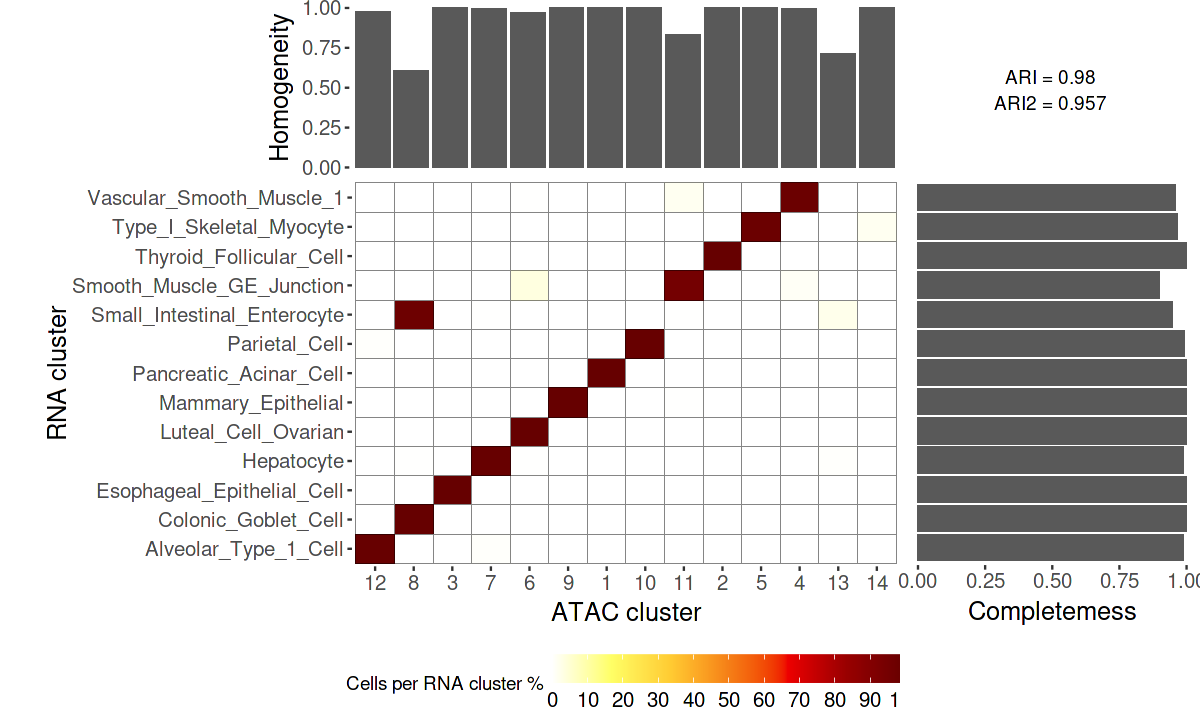

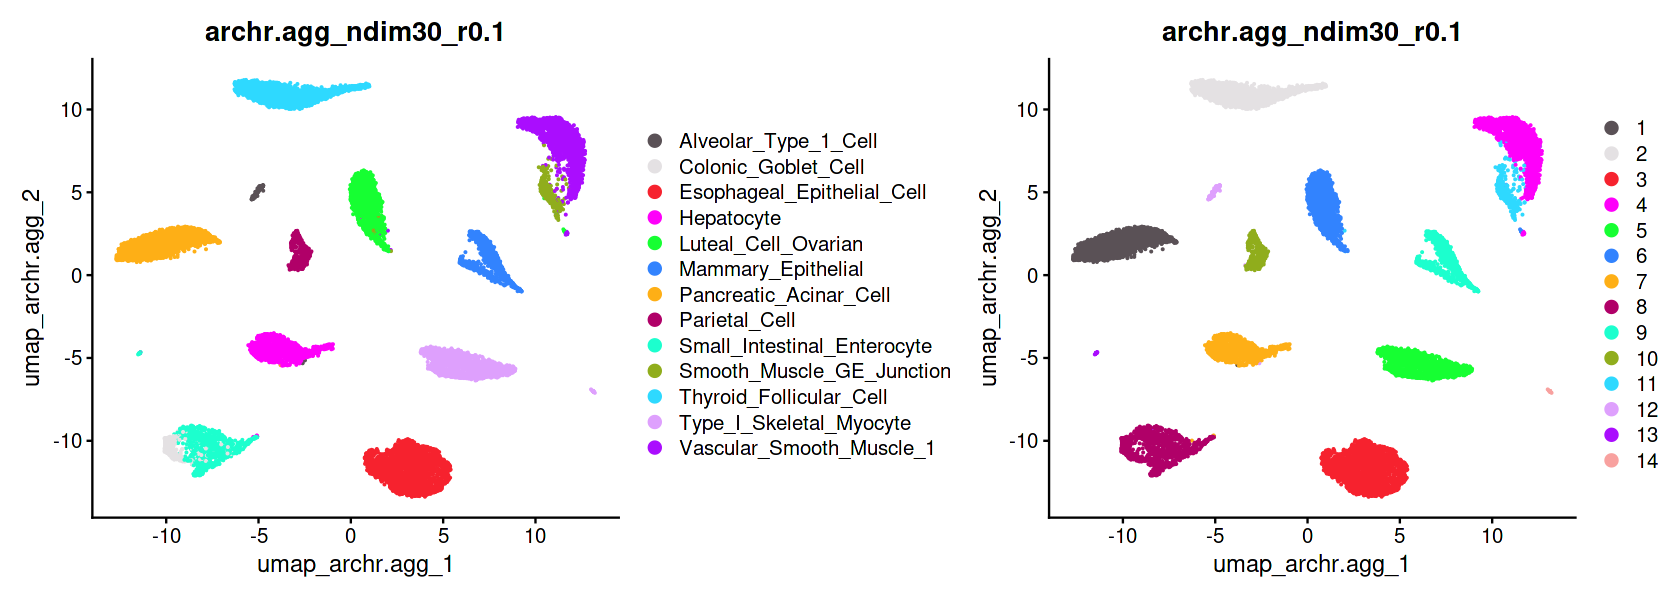

In [54]:
i <- 4
print(df_best[i,])
embed_name <- df_best$method[i]
r <- df_best$resolution[i]
clusterings <- sobj@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
p1 <- cross_table_plot(ground_truth, clusterings, a=1.5, b=5.7, c=2)
p2 <- DimPlot(sobj, reduction = paste0("umap_" ,embed_name), label = F, repel=T, 
        group.by = "ground_truth", cols="polychrome")  + ggtitle(paste0(embed_name, "_ndim", ndim, "_r", r)) 
p3 <- DimPlot(sobj, reduction = paste0("umap_" ,embed_name), label = F, repel=T, 
        group.by = paste0("clustering_" ,embed_name, "_r", r), cols="polychrome")  + ggtitle(paste0(embed_name, "_ndim", ndim, "_r", r)) 


options(repr.plot.width=10, repr.plot.height=6)
p1 
options(repr.plot.width=14, repr.plot.height=5)
p2 + p3

# A tibble: 1 × 4
    ARI resolution method     n_cluster
  <dbl>      <dbl> <chr>          <dbl>
1 0.905       0.35 archr.gene        10


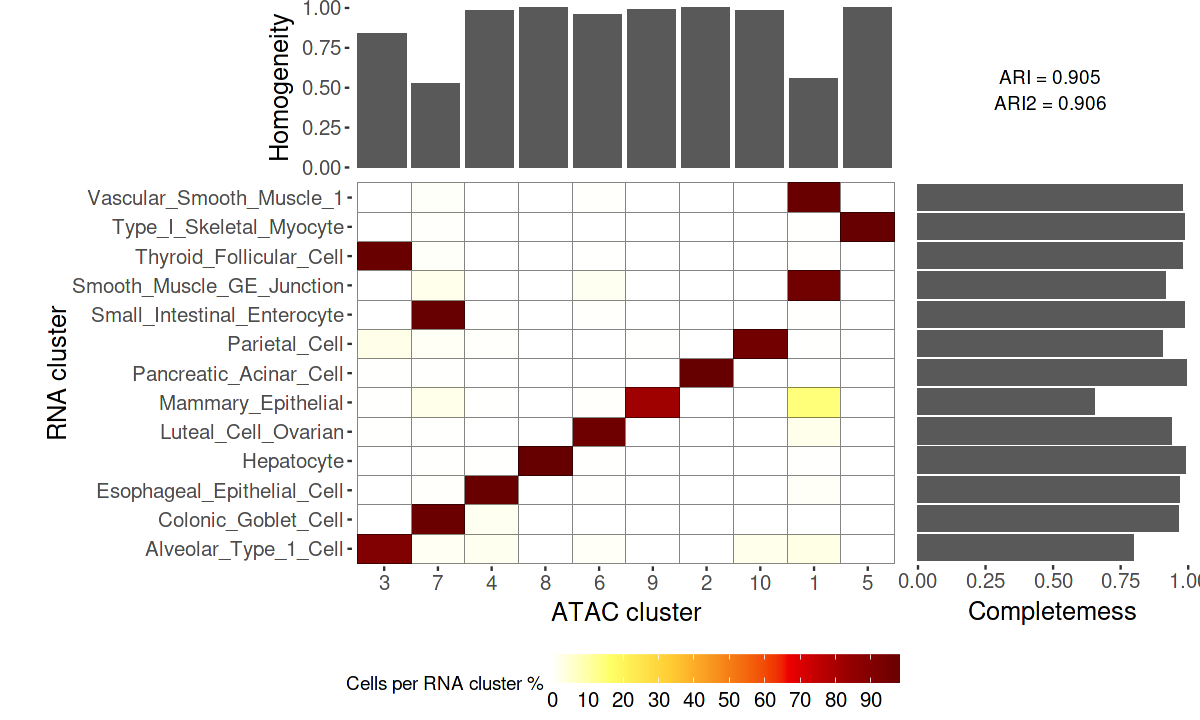

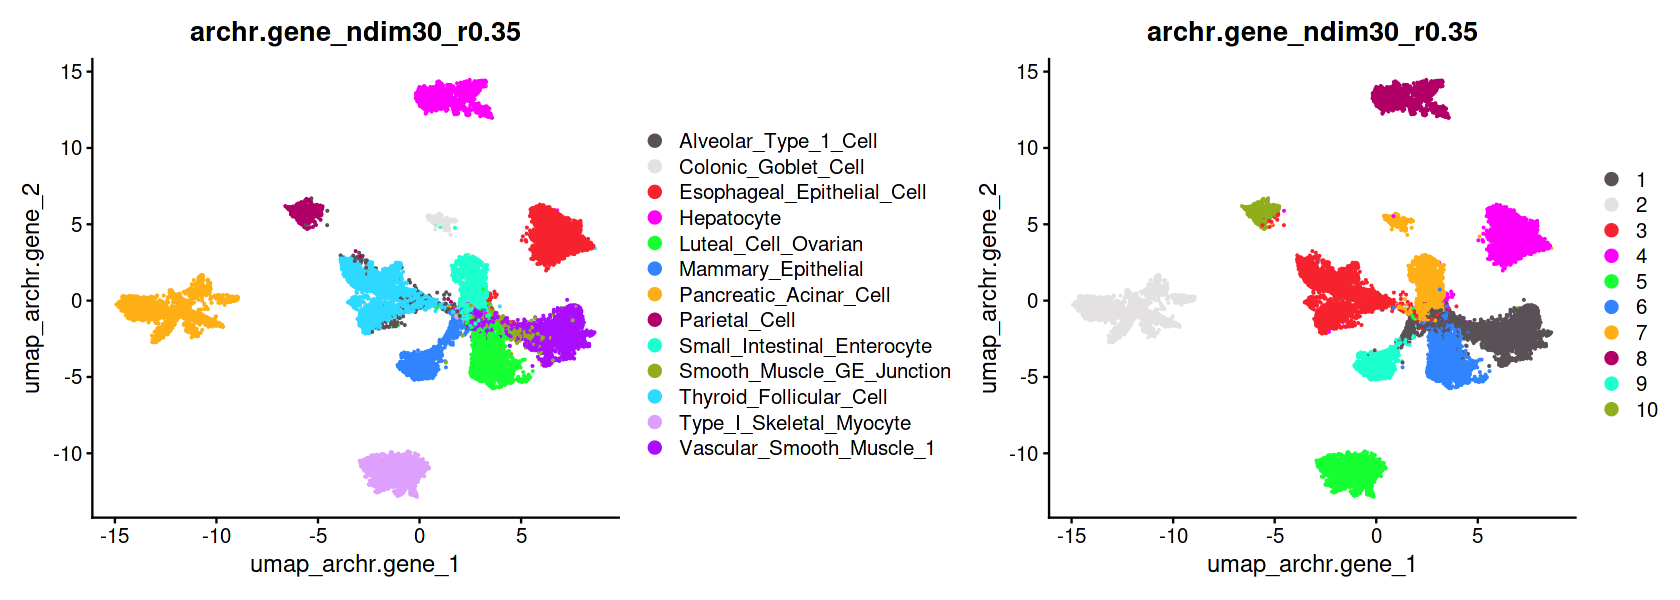

In [55]:
i <- 5
print(df_best[i,])
embed_name <- df_best$method[i]
r <- df_best$resolution[i]
clusterings <- sobj@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
p1 <- cross_table_plot(ground_truth, clusterings, a=1.5, b=5.7, c=2)
p2 <- DimPlot(sobj, reduction = paste0("umap_" ,embed_name), label = F, repel=T, 
        group.by = "ground_truth", cols="polychrome")  + ggtitle(paste0(embed_name, "_ndim", ndim, "_r", r)) 
p3 <- DimPlot(sobj, reduction = paste0("umap_" ,embed_name), label = F, repel=T, 
        group.by = paste0("clustering_" ,embed_name, "_r", r), cols="polychrome")  + ggtitle(paste0(embed_name, "_ndim", ndim, "_r", r)) 


options(repr.plot.width=10, repr.plot.height=6)
p1 
options(repr.plot.width=14, repr.plot.height=5)
p2 + p3

# A tibble: 1 × 4
    ARI resolution method         n_cluster
  <dbl>      <dbl> <chr>              <dbl>
1 0.915       0.35 archr.gene.agg        10


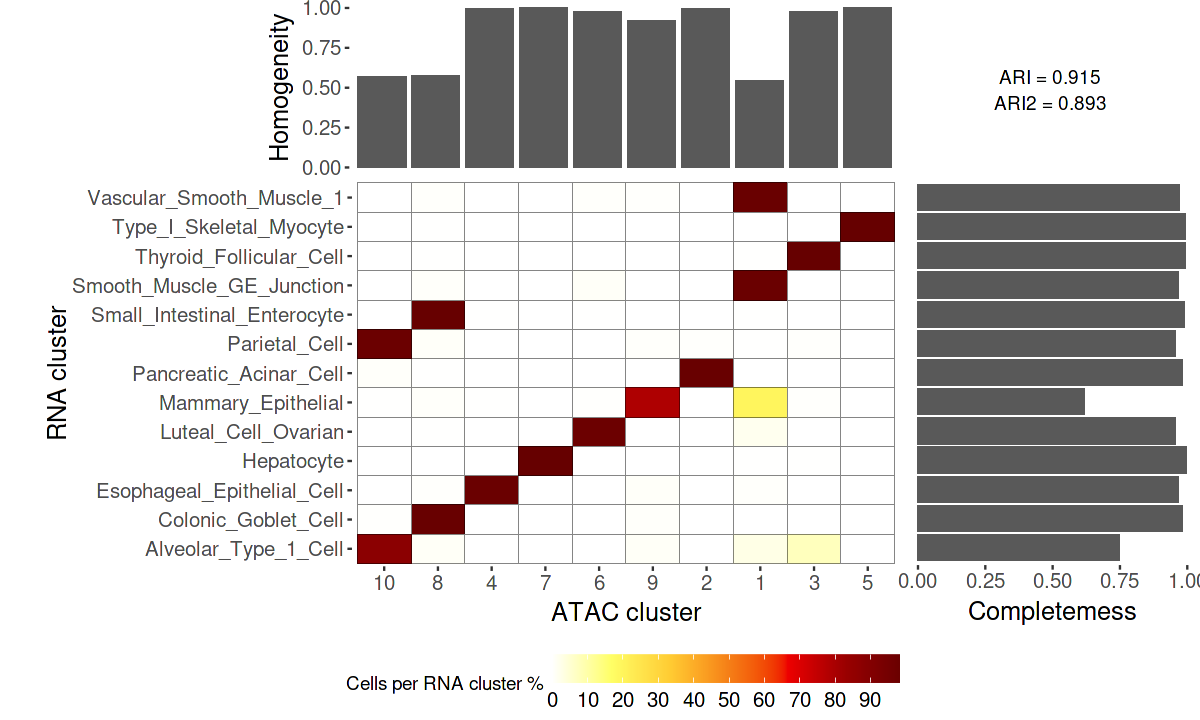

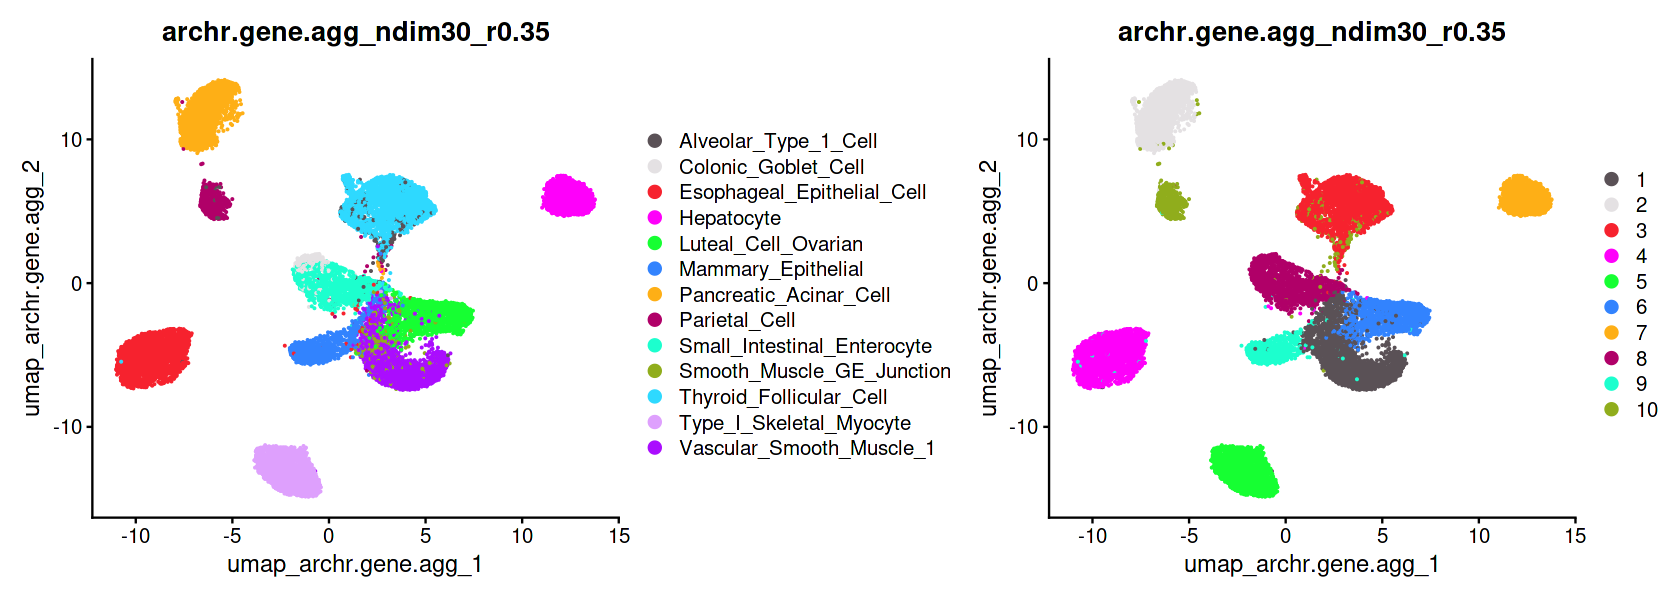

In [56]:
i <- 6
print(df_best[i,])
embed_name <- df_best$method[i]
r <- df_best$resolution[i]
clusterings <- sobj@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
p1 <- cross_table_plot(ground_truth, clusterings, a=1.5, b=5.7, c=2)
p2 <- DimPlot(sobj, reduction = paste0("umap_" ,embed_name), label = F, repel=T, 
        group.by = "ground_truth", cols="polychrome")  + ggtitle(paste0(embed_name, "_ndim", ndim, "_r", r)) 
p3 <- DimPlot(sobj, reduction = paste0("umap_" ,embed_name), label = F, repel=T, 
        group.by = paste0("clustering_" ,embed_name, "_r", r), cols="polychrome")  + ggtitle(paste0(embed_name, "_ndim", ndim, "_r", r)) 


options(repr.plot.width=10, repr.plot.height=6)
p1 
options(repr.plot.width=14, repr.plot.height=5)
p2 + p3

# A tibble: 1 × 4
    ARI resolution method             n_cluster
  <dbl>      <dbl> <chr>                  <dbl>
1 0.997        0.2 signac.twopass.agg        13


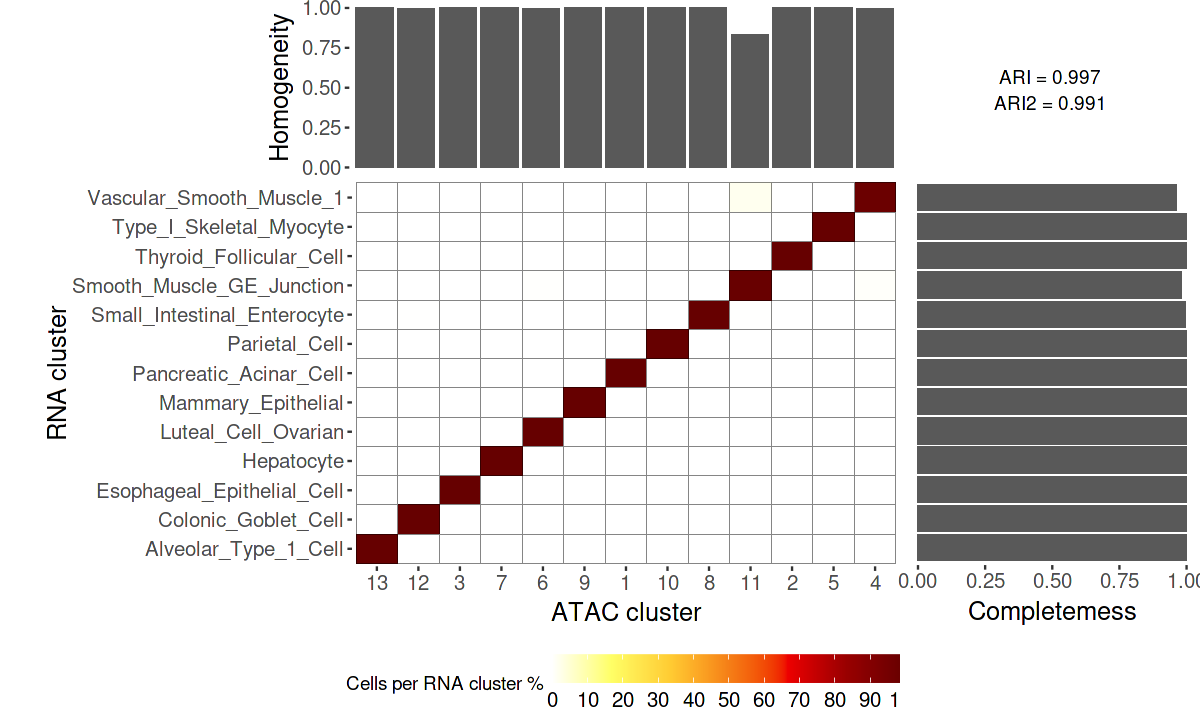

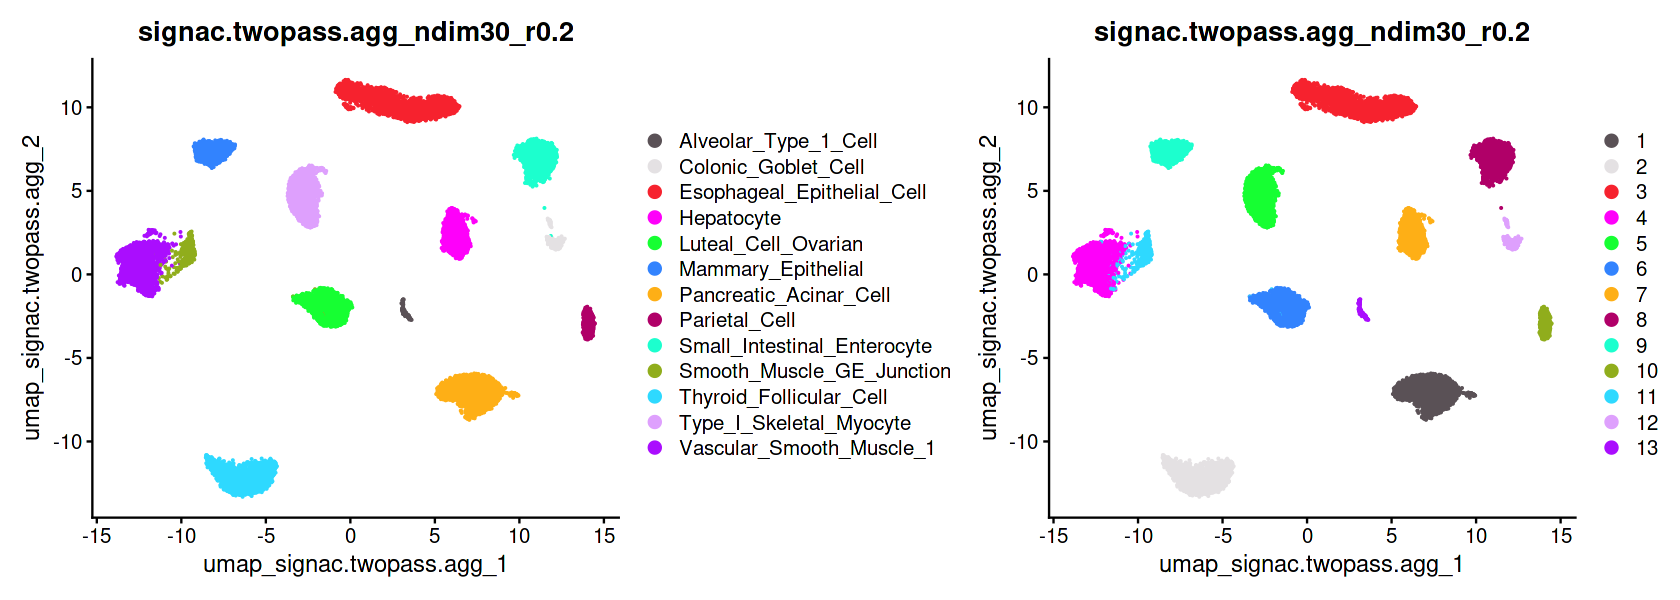

In [57]:
i <- 7
print(df_best[i,])
embed_name <- df_best$method[i]
r <- df_best$resolution[i]
clusterings <- sobj@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
p1 <- cross_table_plot(ground_truth, clusterings, a=1.5, b=5.7, c=2)
p2 <- DimPlot(sobj, reduction = paste0("umap_" ,embed_name), label = F, repel=T, 
        group.by = "ground_truth", cols="polychrome")  + ggtitle(paste0(embed_name, "_ndim", ndim, "_r", r)) 
p3 <- DimPlot(sobj, reduction = paste0("umap_" ,embed_name), label = F, repel=T, 
        group.by = paste0("clustering_" ,embed_name, "_r", r), cols="polychrome")  + ggtitle(paste0(embed_name, "_ndim", ndim, "_r", r)) 


options(repr.plot.width=10, repr.plot.height=6)
p1 
options(repr.plot.width=14, repr.plot.height=5)
p2 + p3

## Check the graph

In [63]:
library(igraph)


Attaching package: ‘igraph’


The following object is masked from ‘package:GenomicRanges’:

    union


The following object is masked from ‘package:IRanges’:

    union


The following object is masked from ‘package:S4Vectors’:

    union


The following objects are masked from ‘package:BiocGenerics’:

    normalize, path, union


The following object is masked from ‘package:class’:

    knn


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following object is masked from ‘package:tidyr’:

    crossing


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [59]:
names(sobj@graphs)

[1] "nn_signac.agg"          "snn_signac.agg"         "nn_signac"             
 [4] "snn_signac"             "nn_signac.twopass.agg"  "snn_signac.twopass.agg"
 [7] "nn_archr.gene"          "snn_archr.gene"         "nn_archr.gene.agg"     
[10] "snn_archr.gene.agg"     "nn_archr"               "snn_archr"             
[13] "nn_archr.agg"           "snn_archr.agg"

In [61]:
df_best

ARI       resolution method             n_cluster
1 0.9910685 0.35       signac.agg         13       
2 0.9555852 0.20       signac             11       
3 0.9514962 0.15       archr              11       
4 0.9796228 0.10       archr.agg          14       
5 0.9051215 0.35       archr.gene         10       
6 0.9151554 0.35       archr.gene.agg     10       
7 0.9965073 0.20       signac.twopass.agg 13

In [67]:
g2 <- sobj@graphs[['snn_signac']]
attributes(g2)$class <- "dgCMatrix"
g2 <- graph_from_adjacency_matrix(adjmatrix = g2, mode = "undirected", weighted = TRUE, add.colnames = TRUE)

In [68]:
# check the graph
g1 <- sobj@graphs[['snn_signac.agg']]
attributes(g1)$class <- "dgCMatrix"
g1 <- graph_from_adjacency_matrix(adjmatrix = g1, mode = "undirected", weighted = TRUE, add.colnames = TRUE)

g2 <- sobj@graphs[['snn_signac']]
attributes(g2)$class <- "dgCMatrix"
g2 <- graph_from_adjacency_matrix(adjmatrix = g2, mode = "undirected", weighted = TRUE, add.colnames = TRUE)

g3 <- sobj@graphs[['snn_archr']]
attributes(g3)$class <- "dgCMatrix"
g3 <- graph_from_adjacency_matrix(adjmatrix = g3, mode = "undirected", weighted = TRUE, add.colnames = TRUE)

g4 <- sobj@graphs[['snn_archr.agg']]
attributes(g4)$class <- "dgCMatrix"
g4 <- graph_from_adjacency_matrix(adjmatrix = g4, mode = "undirected", weighted = TRUE, add.colnames = TRUE)

g5 <- sobj@graphs[['snn_archr.gene']]
attributes(g5)$class <- "dgCMatrix"
g5 <- graph_from_adjacency_matrix(adjmatrix = g5, mode = "undirected", weighted = TRUE, add.colnames = TRUE)

g6 <- sobj@graphs[['snn_archr.gene.agg']]
attributes(g6)$class <- "dgCMatrix"
g6 <- graph_from_adjacency_matrix(adjmatrix = g6, mode = "undirected", weighted = TRUE, add.colnames = TRUE)

g7 <- sobj@graphs[['snn_signac.twopass.agg']]
attributes(g7)$class <- "dgCMatrix"
g7 <- graph_from_adjacency_matrix(adjmatrix = g7, mode = "undirected", weighted = TRUE, add.colnames = TRUE)

### Signac

In [76]:
V(g1)$cluster <- ground_truth
V(g2)$cluster <- ground_truth
V(g7)$cluster <- ground_truth

In [77]:
idx <- ground_truth == "Vascular_Smooth_Muscle_1" | ground_truth == "Smooth_Muscle_GE_Junction" 
muscle_v1 <- V(g1)[idx]
muscle_v2 <- V(g2)[idx]
muscle_v7 <- V(g7)[idx]
g1_muscle <- subgraph(g1, muscle_v1)
g2_muscle <- subgraph(g2, muscle_v2)
g7_muscle <- subgraph(g7, muscle_v7)

V(g1_muscle)$color <- V(g1_muscle)$cluster
V(g1_muscle)$color <- gsub("Vascular_Smooth_Muscle_1","red", V(g1_muscle)$color)
V(g1_muscle)$color <- gsub("Smooth_Muscle_GE_Junction" ,"white", V(g1_muscle)$color)

V(g2_muscle)$color <- V(g2_muscle)$cluster
V(g2_muscle)$color <- gsub("Vascular_Smooth_Muscle_1","red", V(g2_muscle)$color)
V(g2_muscle)$color <- gsub("Smooth_Muscle_GE_Junction" ,"white", V(g2_muscle)$color)

V(g7_muscle)$color <- V(g7_muscle)$cluster
V(g7_muscle)$color <- gsub("Vascular_Smooth_Muscle_1","red", V(g7_muscle)$color)
V(g7_muscle)$color <- gsub("Smooth_Muscle_GE_Junction" ,"white", V(g7_muscle)$color)

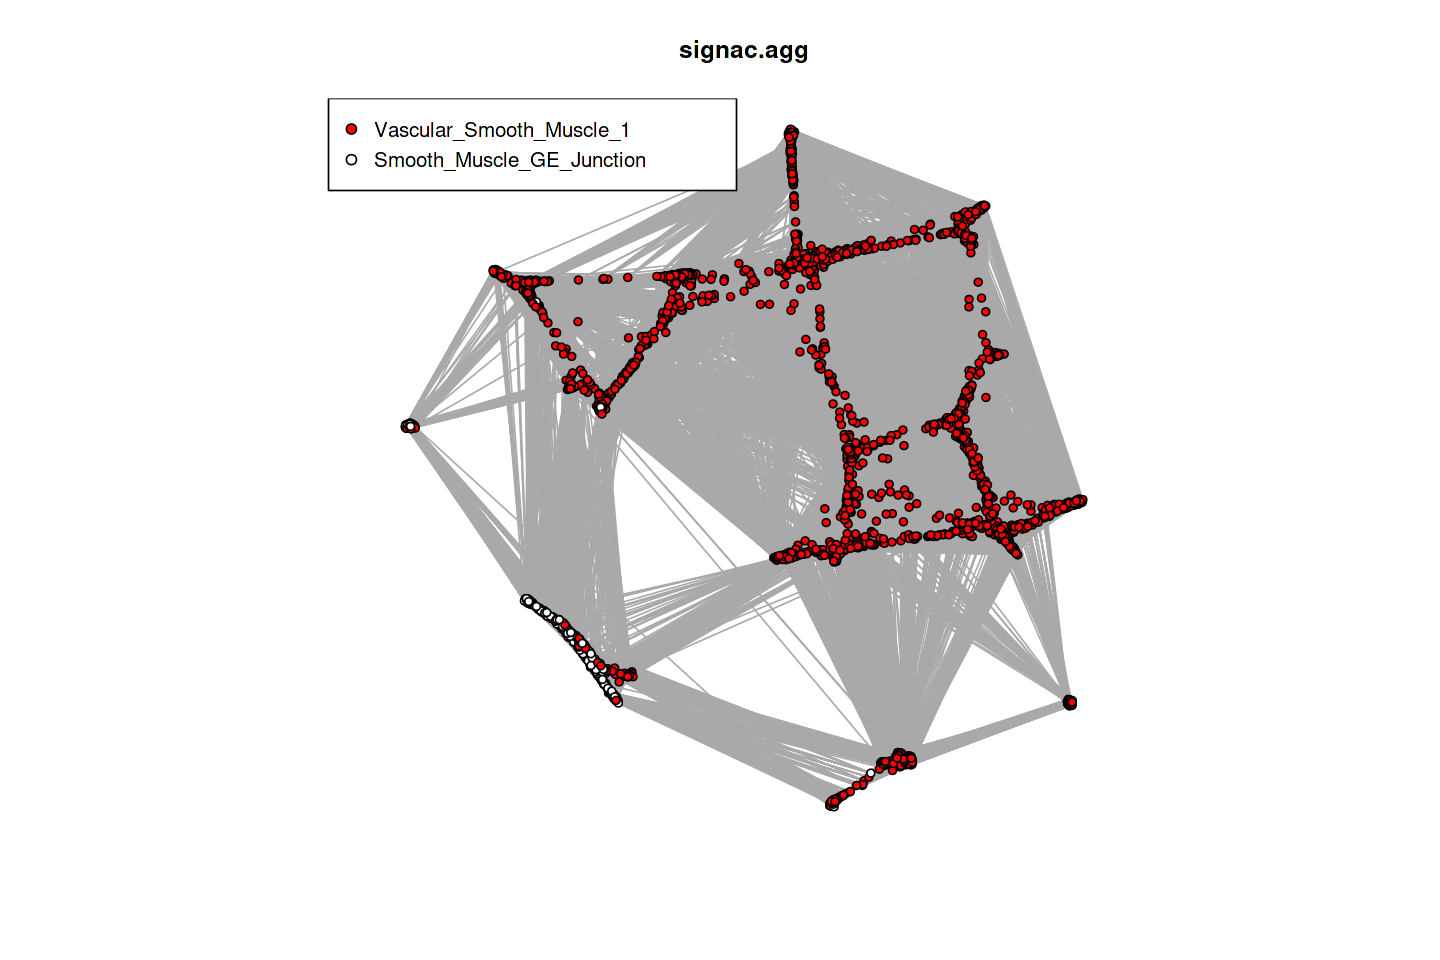

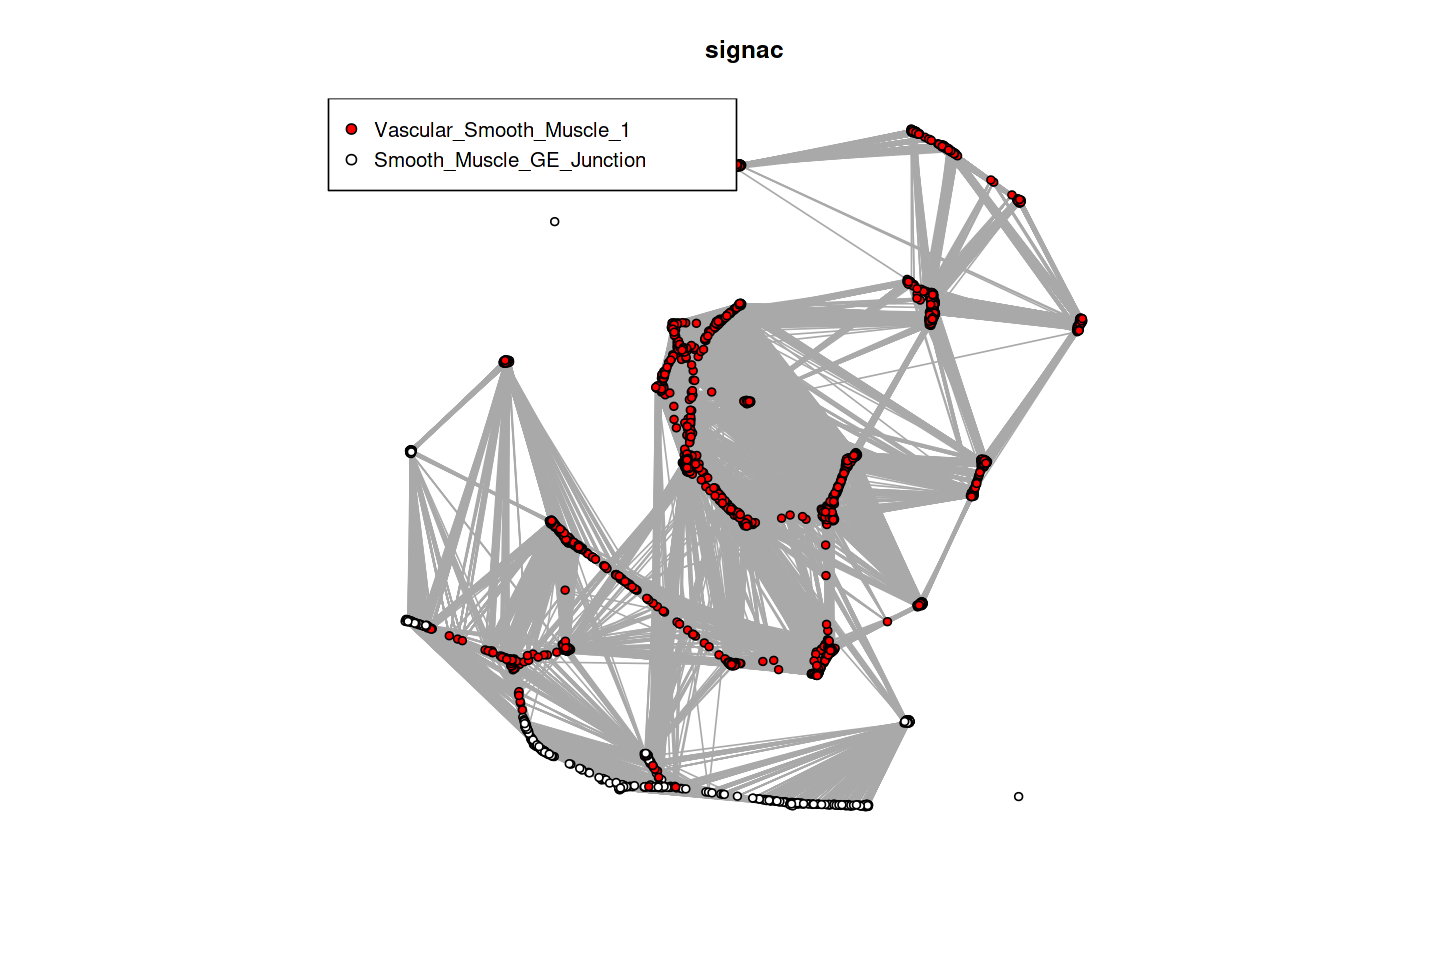

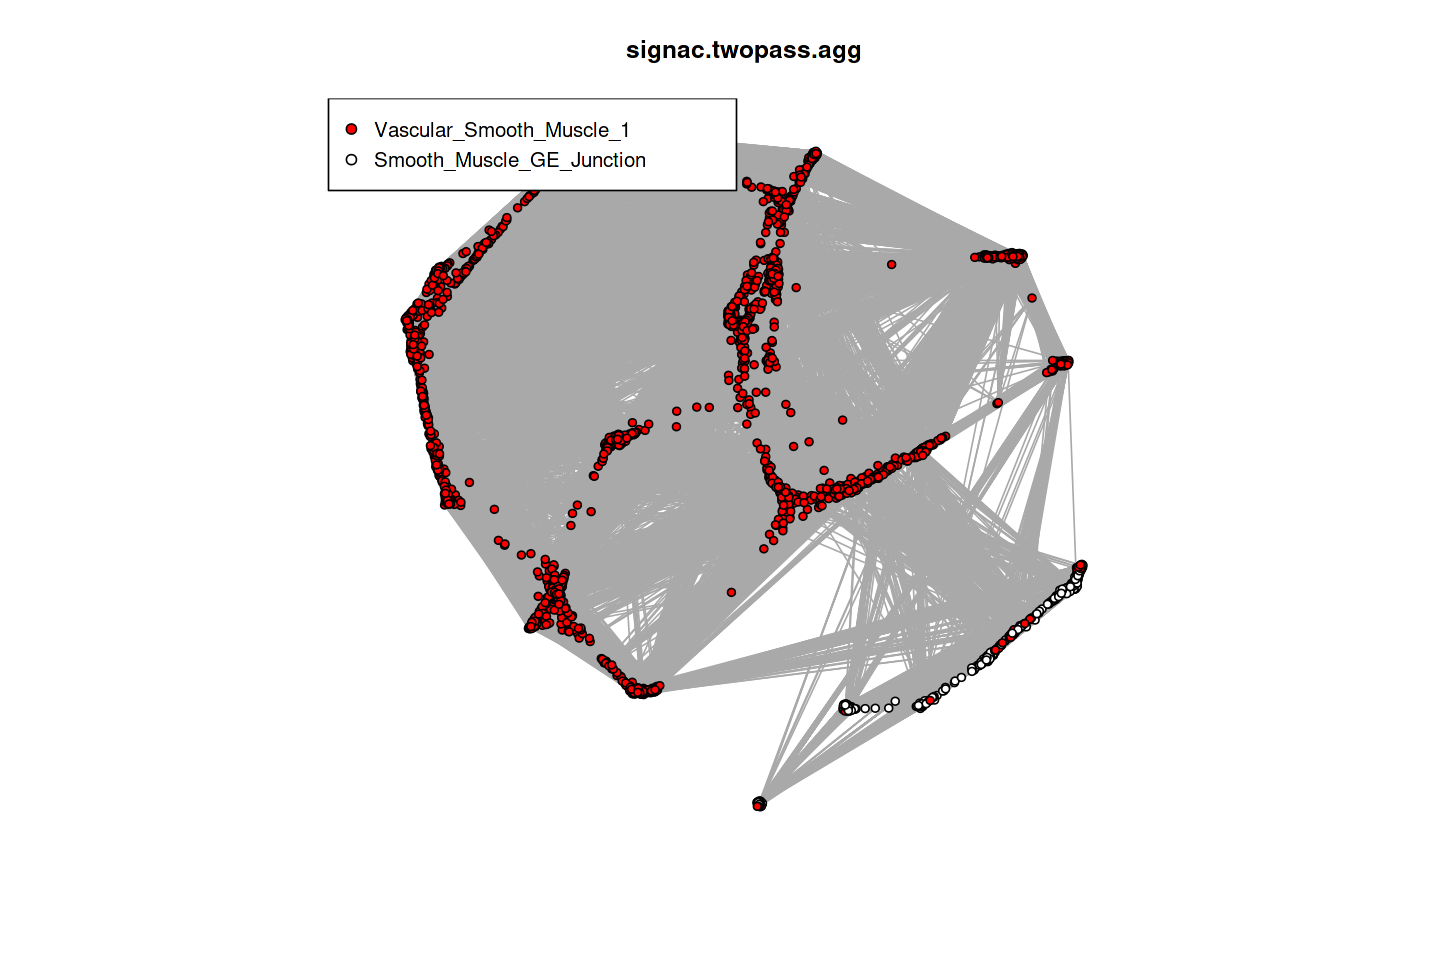

In [78]:
options(repr.plot.width=12, repr.plot.height=8)
plot(simplify(g1_muscle), vertex.label=NA, vertex.size=2, main="signac.agg")  # remove loops and duplicated edges 
legend("topleft", legend=c("Vascular_Smooth_Muscle_1", "Smooth_Muscle_GE_Junction"), pch=21, pt.bg=c("red","white"))
plot(simplify(g2_muscle), vertex.label=NA, vertex.size=2, main="signac")  # remove loops and duplicated edges 
legend("topleft", legend=c("Vascular_Smooth_Muscle_1", "Smooth_Muscle_GE_Junction"), pch=21, pt.bg=c("red","white"))
plot(simplify(g7_muscle), vertex.label=NA, vertex.size=2, main="signac.twopass.agg")  # remove loops and duplicated edges 
legend("topleft", legend=c("Vascular_Smooth_Muscle_1", "Smooth_Muscle_GE_Junction"), pch=21, pt.bg=c("red","white"))

In [79]:
# muscle
community_strength(g1_muscle, V(g1_muscle)$cluster,1)
community_strength(g1_muscle, V(g1_muscle)$cluster,2)

$j1
[1] 9

$j1_frac
[1] 0.003841229

$w1
[1] 3

$w1_frac
[1] 0.00128041

$j1
[1] 8

$j1_frac
[1] 0.01606426

$w1
[1] 6

$w1_frac
[1] 0.01204819

In [80]:
# muscle
community_strength(g2_muscle, V(g2_muscle)$cluster,1)
community_strength(g2_muscle, V(g2_muscle)$cluster,2)

$j1
[1] 15

$j1_frac
[1] 0.006402049

$w1
[1] 9

$w1_frac
[1] 0.003841229

$j1
[1] 14

$j1_frac
[1] 0.02811245

$w1
[1] 7

$w1_frac
[1] 0.01405622

In [81]:
# muscle
community_strength(g7_muscle, V(g7_muscle)$cluster,1)
community_strength(g7_muscle, V(g7_muscle)$cluster,2)

$j1
[1] 7

$j1_frac
[1] 0.002987623

$w1
[1] 4

$w1_frac
[1] 0.001707213

$j1
[1] 3

$j1_frac
[1] 0.006024096

$w1
[1] 3

$w1_frac
[1] 0.006024096

### ArchR

In [82]:
V(g3)$cluster <- ground_truth
V(g4)$cluster <- ground_truth

In [83]:
idx <- ground_truth == "Vascular_Smooth_Muscle_1" | ground_truth == "Smooth_Muscle_GE_Junction" 
muscle_v3 <- V(g3)[idx]
muscle_v4 <- V(g4)[idx]

g3_muscle <- subgraph(g3, muscle_v3)
g4_muscle <- subgraph(g4, muscle_v4)


V(g3_muscle)$color <- V(g3_muscle)$cluster
V(g3_muscle)$color <- gsub("Vascular_Smooth_Muscle_1","red", V(g3_muscle)$color)
V(g3_muscle)$color <- gsub("Smooth_Muscle_GE_Junction" ,"white", V(g3_muscle)$color)

V(g4_muscle)$color <- V(g4_muscle)$cluster
V(g4_muscle)$color <- gsub("Vascular_Smooth_Muscle_1","red", V(g4_muscle)$color)
V(g4_muscle)$color <- gsub("Smooth_Muscle_GE_Junction" ,"white", V(g4_muscle)$color)

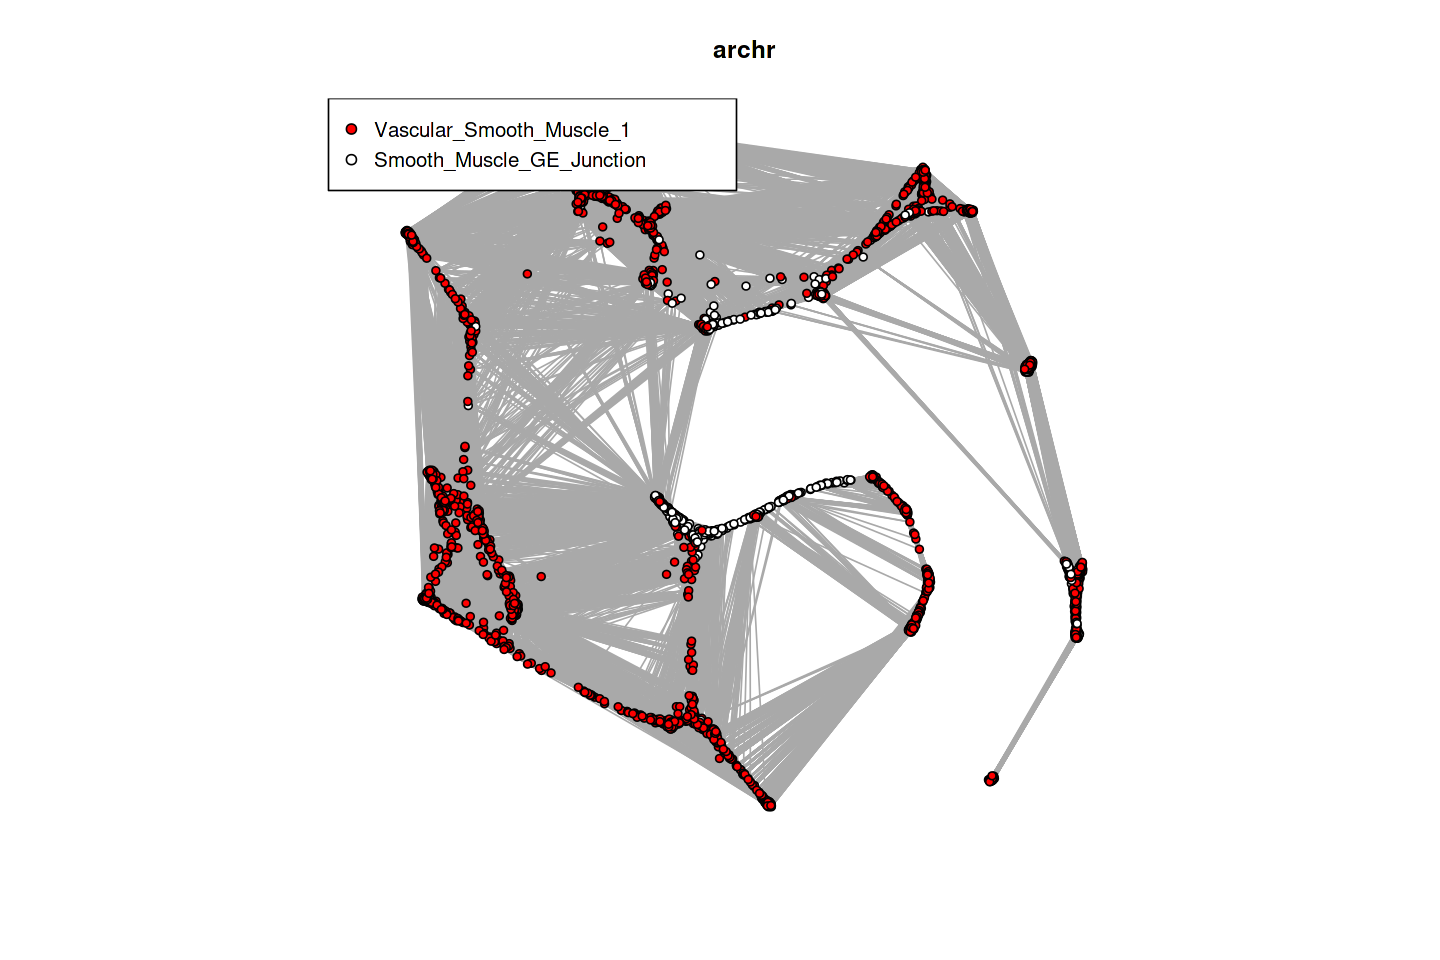

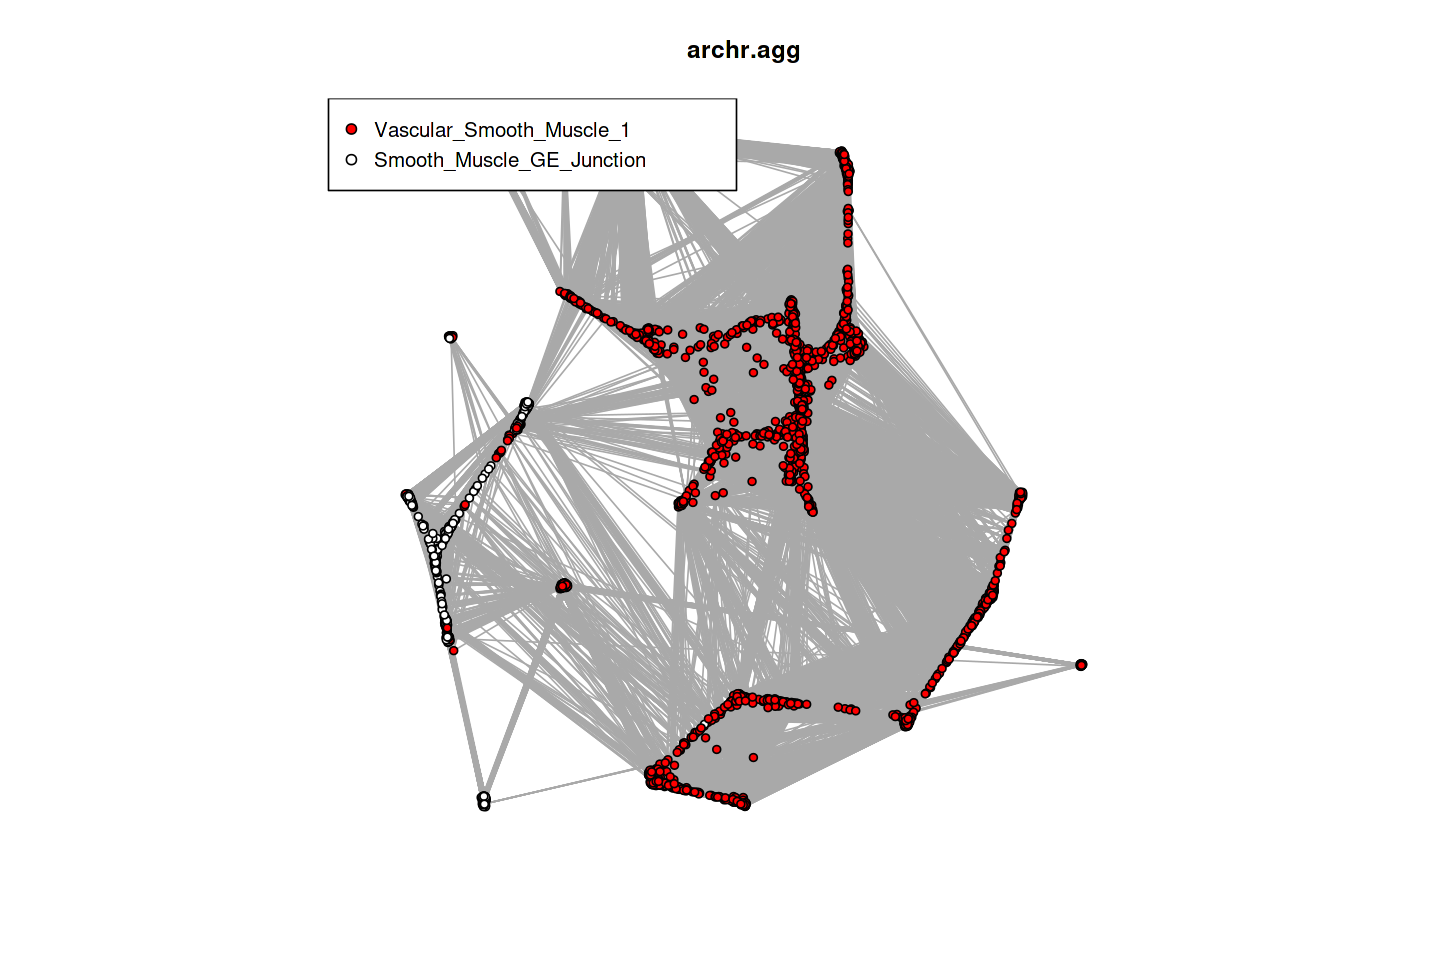

In [84]:
options(repr.plot.width=12, repr.plot.height=8)
plot(simplify(g3_muscle), vertex.label=NA, vertex.size=2, main="archr")  # remove loops and duplicated edges 
legend("topleft", legend=c("Vascular_Smooth_Muscle_1", "Smooth_Muscle_GE_Junction"), pch=21, pt.bg=c("red","white"))
plot(simplify(g4_muscle), vertex.label=NA, vertex.size=2, main="archr.agg")  # remove loops and duplicated edges 
legend("topleft", legend=c("Vascular_Smooth_Muscle_1", "Smooth_Muscle_GE_Junction"), pch=21, pt.bg=c("red","white"))

In [85]:
# muscle
community_strength(g3_muscle, V(g3_muscle)$cluster,1)
community_strength(g3_muscle, V(g3_muscle)$cluster,2)

$j1
[1] 24

$j1_frac
[1] 0.01024328

$w1
[1] 17

$w1_frac
[1] 0.007255655

$j1
[1] 73

$j1_frac
[1] 0.1465863

$w1
[1] 47

$w1_frac
[1] 0.09437751

In [86]:
# muscle
community_strength(g4_muscle, V(g4_muscle)$cluster,1)
community_strength(g4_muscle, V(g4_muscle)$cluster,2)

$j1
[1] 12

$j1_frac
[1] 0.005121639

$w1
[1] 5

$w1_frac
[1] 0.002134016

$j1
[1] 2

$j1_frac
[1] 0.004016064

$w1
[1] 1

$w1_frac
[1] 0.002008032

## Gene score

In [87]:
V(g5)$cluster <- ground_truth
V(g6)$cluster <- ground_truth

In [88]:
idx <- ground_truth == "Vascular_Smooth_Muscle_1" | ground_truth == "Smooth_Muscle_GE_Junction" 
muscle_v5 <- V(g5)[idx]
muscle_v6 <- V(g6)[idx]

g5_muscle <- subgraph(g5, muscle_v5)
g6_muscle <- subgraph(g6, muscle_v6)


V(g5_muscle)$color <- V(g5_muscle)$cluster
V(g5_muscle)$color <- gsub("Vascular_Smooth_Muscle_1","red", V(g5_muscle)$color)
V(g5_muscle)$color <- gsub("Smooth_Muscle_GE_Junction" ,"white", V(g5_muscle)$color)

V(g6_muscle)$color <- V(g6_muscle)$cluster
V(g6_muscle)$color <- gsub("Vascular_Smooth_Muscle_1","red", V(g6_muscle)$color)
V(g6_muscle)$color <- gsub("Smooth_Muscle_GE_Junction" ,"white", V(g6_muscle)$color)

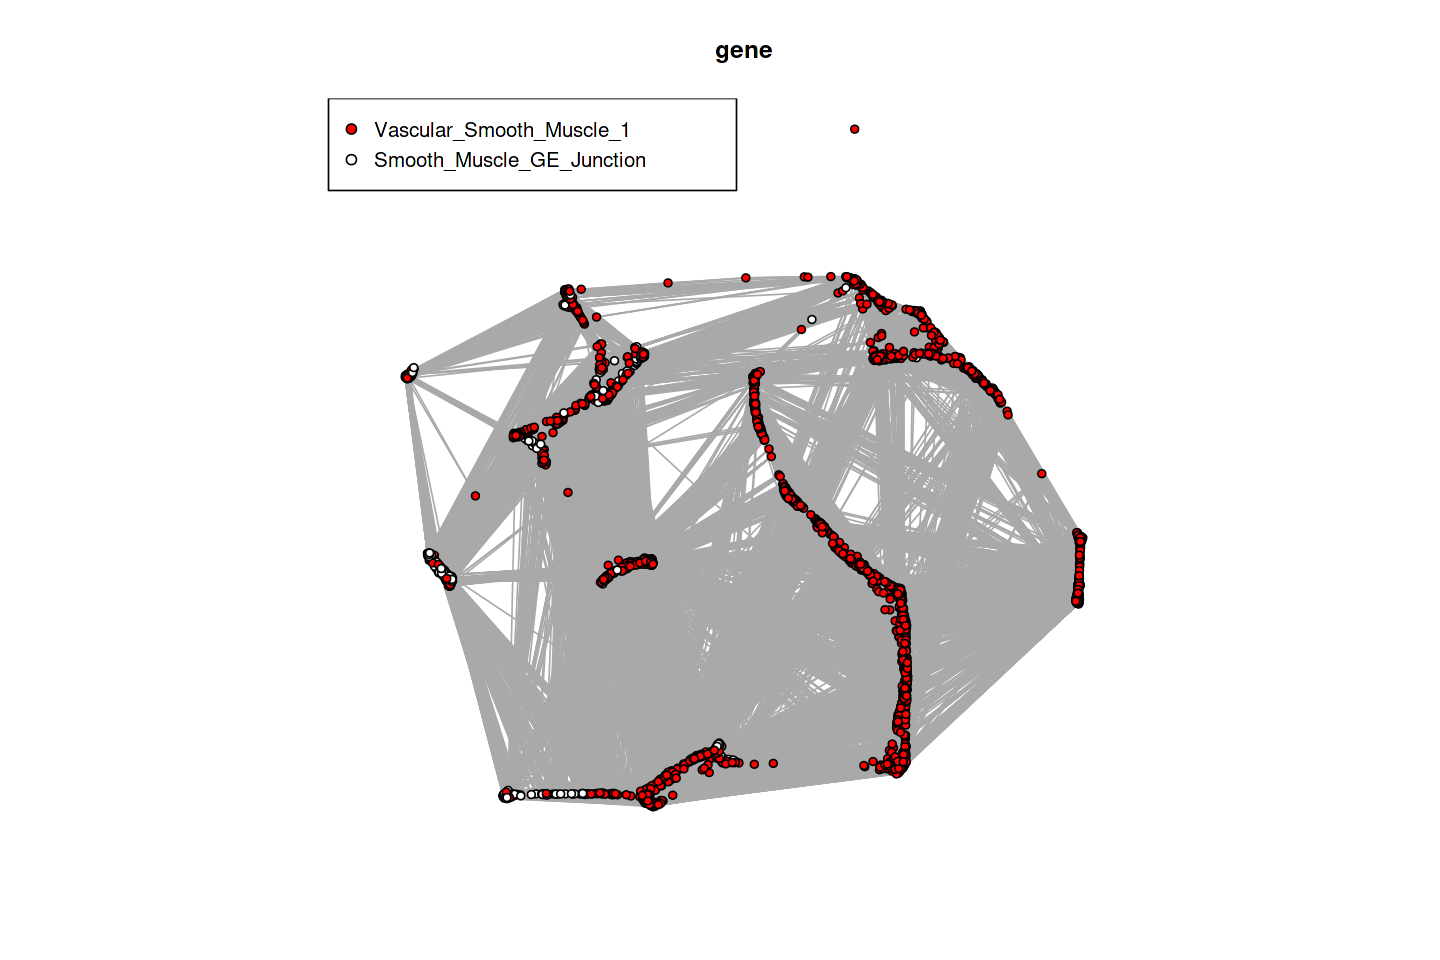

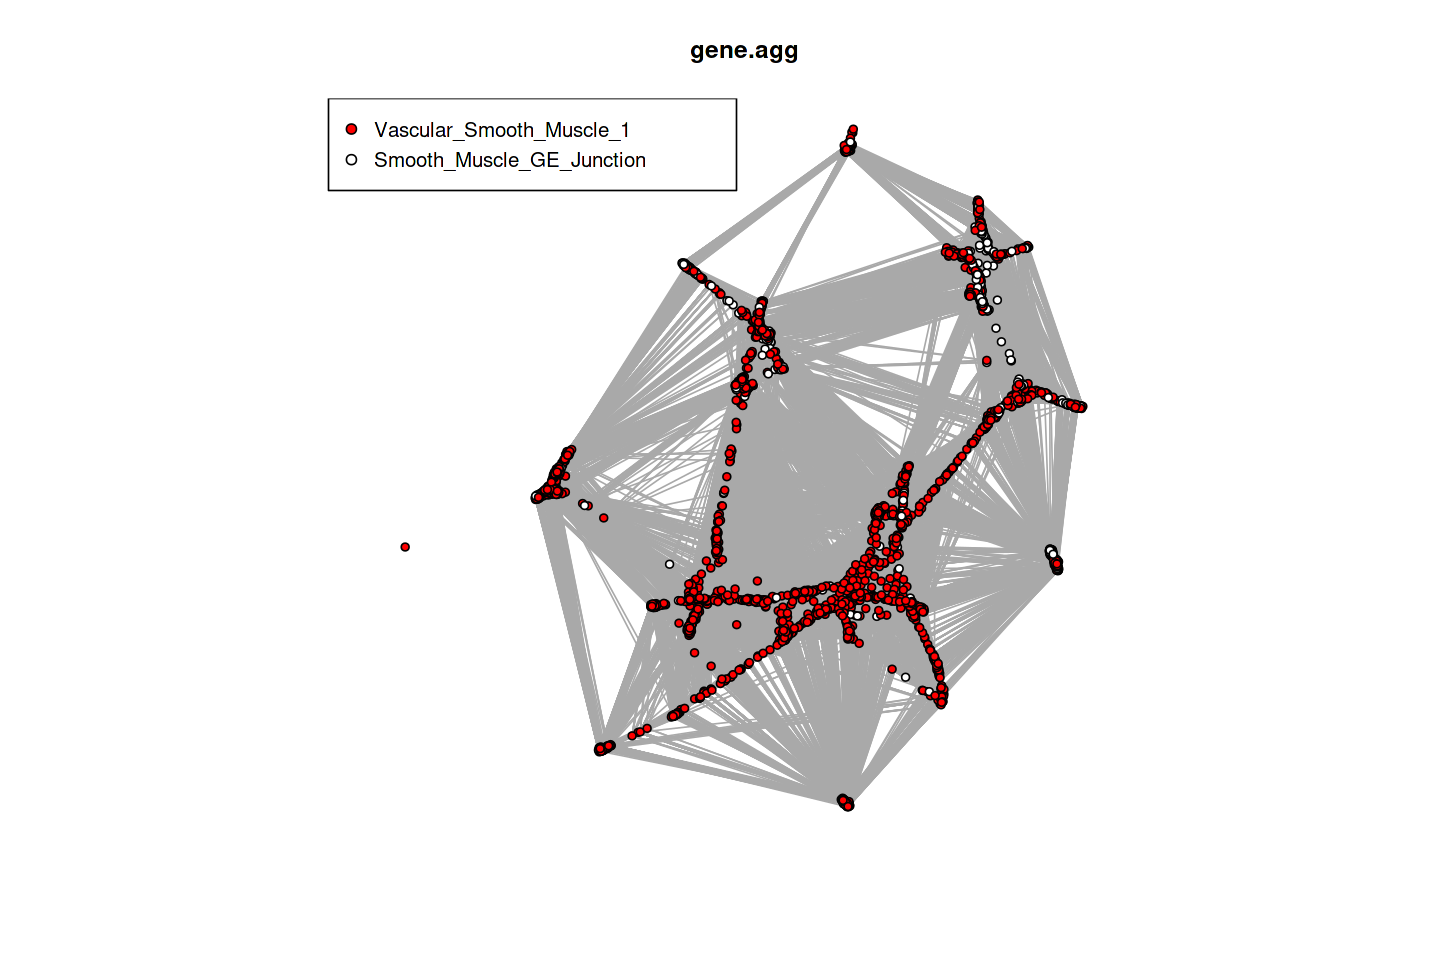

In [89]:
options(repr.plot.width=12, repr.plot.height=8)
plot(simplify(g5_muscle), vertex.label=NA, vertex.size=2, main="gene")  # remove loops and duplicated edges 
legend("topleft", legend=c("Vascular_Smooth_Muscle_1", "Smooth_Muscle_GE_Junction"), pch=21, pt.bg=c("red","white"))
plot(simplify(g6_muscle), vertex.label=NA, vertex.size=2, main="gene.agg")  # remove loops and duplicated edges 
legend("topleft", legend=c("Vascular_Smooth_Muscle_1", "Smooth_Muscle_GE_Junction"), pch=21, pt.bg=c("red","white"))

In [90]:
# muscle
community_strength(g5_muscle, V(g5_muscle)$cluster,1)
community_strength(g5_muscle, V(g5_muscle)$cluster,2)

$j1
[1] 39

$j1_frac
[1] 0.01664533

$w1
[1] 24

$w1_frac
[1] 0.01024328

$j1
[1] 97

$j1_frac
[1] 0.1947791

$w1
[1] 61

$w1_frac
[1] 0.12249

In [91]:
# muscle
community_strength(g6_muscle, V(g6_muscle)$cluster,1)
community_strength(g6_muscle, V(g6_muscle)$cluster,2)

$j1
[1] 28

$j1_frac
[1] 0.01195049

$w1
[1] 21

$w1_frac
[1] 0.008962868

$j1
[1] 138

$j1_frac
[1] 0.2771084

$w1
[1] 87

$w1_frac
[1] 0.1746988